In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl

## Utilities from Will Chapman
import utilities


warnings.filterwarnings('ignore')


In [2]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_region(minLat,maxLat,minLon,maxLon, DS, ocnDS = [], ocnMask=False): 
    iLat  = np.where( (DS['lat']>=minLat) & (DS['lat']<=maxLat) )[0]
    iLon  = np.where( (DS['lon']>=minLon) & (DS['lon']<=maxLon) )[0]
    
    if ocnMask==True:
        selOcn = ocnDS[iLat,:]
        
        return selOcn[:,iLon]
            
    return DS.isel(lat=iLat, lon=iLon)

def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
    
    return np.sqrt( wmse ).item()

    

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [4]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess(ds):
    dsCorr         = cesm_correct_time(ds)
    return dsCorr

def preprocess_daily(ds):
    ds             = ds
    dsCorr         = cesm_correct_time(ds)
    return dsCorr[['U850','PRECT']]

In [5]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

## Set up dask

In [6]:
import dask
dask.config.set({'logging.distributed': 'error'})


In [7]:
from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="02:00:00",
    project="P93300642",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)


In [8]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

<Client: 'tcp://128.117.208.119:45435' processes=0 threads=0, memory=0 B>

In [9]:
cluster.scale(24)


In [10]:
client.wait_for_workers(24)


## Read in data

In [11]:
%%time 
testDir     = '/glade/derecho/scratch/hannay/archive/'

case_IDs  = [
               # 'BLT1850_054ctrl',
               # 'BLT1850_064gust',    
               'BLT1850_082b_1xGust',   
               # 'BLT1850_081b_3xGust',   
               'BLT1850_083b_0xGust',   
              ]

caseNames = [
            'b.e23_alpha16g.BLT1850.ne30_t232.082b',
            # 'b.e23_alpha16g.BLT1850.ne30_t232.081b',
            'b.e23_alpha16g.BLT1850.ne30_t232.083b']
    
for iCase in tqdm(range(len(case_IDs))):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Select just the first thirty years 
    listFiles_h0 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h0.????-*'))[(10*12):(60*12)]
    listFiles_h1 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h2.????-*'))[(10*19):(60*19)]
    # listFiles_h0 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h0.????-*'))[(1*12):(50*12)]
    # listFiles_h1 = np.sort(glob.glob(testDir+caseNames[iCase]+'/atm/hist/*cam.h2.????-*'))[(1*19):(50*19)]
    
    ## Now read in those files
    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_daily, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})
    
    # ## Info on dates available
    # print('Min year (h0): ', np.nanmin(case_h0['time.year'].values))
    # print('Max year (h0): ', np.nanmax(case_h0['time.year'].values))
    # print('Min year (h1): ', np.nanmin(case_h1['time.year'].values))
    # print('Max year (h1): ', np.nanmax(case_h1['time.year'].values))
    
    ## Return all the cases in a single dataset
    if iCase==0:
        all_h0    = case_h0
        del case_h0
        all_h1 = case_h1
        del case_h1
    else: 
        all_h0    = xr.concat([all_h0, case_h0], "case") 
        del case_h0
        all_h1 = xr.concat([all_h1, case_h1], "case") 
        del case_h1
    

  0%|          | 0/2 [00:00<?, ?it/s]

*** Starting on case BLT1850_082b_1xGust ***
h0 files loaded


 50%|█████     | 1/2 [11:57<11:57, 717.20s/it]

h1 files loaded
*** Starting on case BLT1850_083b_0xGust ***
h0 files loaded
h1 files loaded


100%|██████████| 2/2 [24:37<00:00, 738.54s/it]

CPU times: user 7min 12s, sys: 38.4 s, total: 7min 50s
Wall time: 24min 37s


In [12]:
# U850 = all_h0.U.sel(lev=850, method='nearest')
all_h0['U850'] = all_h0.U.sel(lev=850, method='nearest')
all_h0['U200'] = all_h0.U.sel(lev=200, method='nearest')

all_h0['V850'] = all_h0.V.sel(lev=850, method='nearest')
all_h0['V200'] = all_h0.V.sel(lev=200, method='nearest')

all_h0['OMEGA200'] = all_h0.OMEGA.sel(lev=200, method='nearest')
all_h0['OMEGA500'] = all_h0.OMEGA.sel(lev=500, method='nearest')


In [13]:
all_h0.time

<xarray.DataArray 'time' (time: 588)>
array([cftime.DatetimeNoLeap(2, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2, 3, 16, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(50, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(50, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(50, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 0002-01-16 12:00:00 ... 0050-12-16 12:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [12]:
# listFiles_h0[0:4]
# listFiles_h0[-4::]


## First need to define ENSO phase

In [13]:
from dateutil.relativedelta import relativedelta
def add_months(start_date, num_months):
    return start_date + relativedelta(months=num_months)

def monthly_time_array(start_date, num_months):
    # Convert the start date string to a datetime object
    # start_date = datetime.strptime(start_date, '%Y-%m-%d')

    # Create a list to store the monthly time array
    time_array = []

    # Generate monthly time array
    for i in range(num_months):
        time_array.append(start_date)
        start_date = add_months(start_date, 1)

    return time_array


In [14]:
## To make life a bit easier, let's assign "real" dates 
start_date = datetime.datetime(1850, 1, 15)
num_months = len(all_h0.time.values)
result = monthly_time_array(start_date, num_months)

all_h0['time'] = result

In [15]:
## Remove annual cycle from variable 
def rmMonAnnCyc(DS,var): 
    
    climatology = DS[var].groupby("time.month").mean("time")
    anomalies = DS[var].groupby("time.month") - climatology    

    return anomalies


In [16]:
ocnMask = all_h0.OCNFRAC.values
ocnMask[ocnMask==0] = np.nan

In [18]:
## Define just SST (mask out land)
all_h0['SST']     = all_h0.TS * ocnMask

## Remove climatology from SST 
TS_anom = rmMonAnnCyc(all_h0,'SST')

In [18]:
ilats = np.where((TS_anom.lat.values>=-5)  & (TS_anom.lat.values<=5))[0]
ilons = np.where((TS_anom.lon.values>=190) & (TS_anom.lon.values<=240))[0]

# Compute weights 
regionTS = TS_anom.isel(lat=ilats, lon=ilons)
coswgt = np.cos(np.deg2rad(regionTS.lat))

nino34_raw = regionTS.weighted(coswgt).mean(('lon','lat'))


In [19]:
## Compute a running weighted mean, as in the CVDP package 
wgt = [1.,2.,1.]   
wgt = wgt/np.sum(wgt)

weight = xr.DataArray(wgt, dims=['window'])
nino34 = nino34_raw.rolling(time=3, center=True).construct('window').dot(weight)

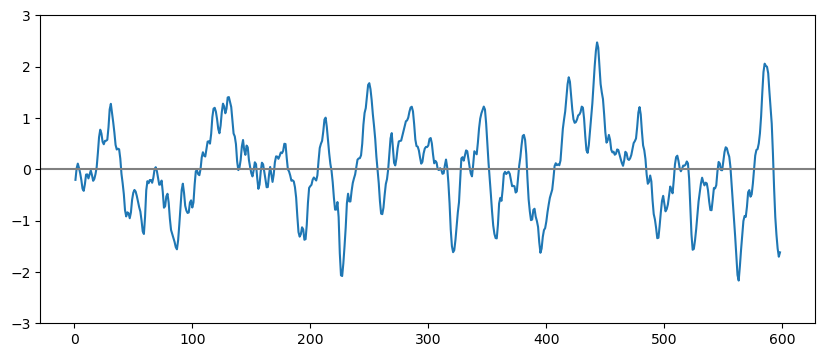

In [45]:
fig,axs = plt.subplots(1,1,figsize=(10,4))

axs.plot(nino34.isel(case=0).values)
axs.set_ylim([-3,3])
axs.axhline(0,color='grey')

## Have compared to CVDP timeseries and they look to be very similar, as expected 

In [15]:
## OLD METHOD - DO NOT USE, INCORRECT 

# ilats = np.where((all_h0.lat.values>=-5)  & (all_h0.lat.values<=5))[0]
# ilons = np.where((all_h0.lon.values>=190) & (all_h0.lon.values<=240))[0]

# regionTS = all_h0.TS.isel(lat=ilats, lon=ilons).mean(dim='lat').mean(dim='lon')
# climoTS  = regionTS.mean(dim='time')

# ## Isolate the nino 3.4 region's SST anomalies over a 5-month rolling mean 
# nino34 = (regionTS - climoTS).rolling(time=5).mean()

# # nino34['time'] = nino34.indexes['time'].to_datetimeindex() 


In [42]:
all_h0['nino34'] = (('case','time'), nino34.values)

In [22]:
nino34.load()

<xarray.DataArray (case: 2, time: 600)>
array([[        nan, -0.20583889,  0.01884446, ..., -1.70357386,
        -1.61848442,         nan],
       [        nan, -1.10567476, -1.13157473, ..., -1.4202151 ,
        -1.60366087,         nan]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-15 ... 1899-12-15
  * case     (case) <U19 'BLT1850_082b_1xGust' 'BLT1850_083b_0xGust'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [23]:
## Identify winters that are in different ENSO phases?
#    ENSO active when anomaly +/- 0.4 deg for 6+ months

label_case0 = np.full([len(nino34.time.values)], '---------')
label_case1 = np.full([len(nino34.time.values)], '---------')
# label_case2 = np.full([len(nino34.time.values)], '---------')

for iTime in tqdm(range(6, len(nino34.time.values)-6)):
    # to select the previous six months **including** the current one with np.arange, you need to 
    #   add one the ending number (to be the present iTime), and thus only subtract 5 months 
    this6months_case0 = nino34.isel(case=0).isel(time=np.arange(iTime-5,iTime+1))
    this6months_case1 = nino34.isel(case=1).isel(time=np.arange(iTime-5,iTime+1))
    # this6months_case2 = nino34.isel(case=2).isel(time=np.arange(iTime-5,iTime+1))

    # Case 0
    if (np.all(this6months_case0.values>=0.4)):
        label_case0[iTime] = 'ElNino'
    elif (np.all(this6months_case0.values<=-0.4)):
        label_case0[iTime] = 'LaNina'
    # elif ( (np.all(this6months_case0.values<=-0.4) == False) & (np.all(this6months_case0.values>=0.4)==False) ):
    elif ( (np.all(np.abs(this6months_case0.values)<-0.4) == False) & (np.all(this6months_case0.values>0.4)==False) ):
        label_case0[iTime] = 'Neutral'

    # Case 1
    if (np.all(this6months_case1.values>=0.4)):
        label_case1[iTime] = 'ElNino'
    elif (np.all(this6months_case1.values<=-0.4)):
        label_case1[iTime] = 'LaNina'
    elif ( (np.all(this6months_case1.values<-0.4) == False) & (np.all(this6months_case1.values>0.4)==False) ):
        label_case1[iTime] = 'Neutral'

    # # Case 2
    # if (np.all(this6months_case2.values>=0.4)):
    #     label_case2[iTime] = 'ElNino'
    # elif (np.all(this6months_case2.values<=-0.4)):
    #     label_case2[iTime] = 'LaNina'
    # elif ( (np.all(this6months_case2.values<-0.4) == False) & (np.all(this6months_case2.values>0.4)==False) ):
    #     label_case2[iTime] = 'Neutral'


100%|██████████| 588/588 [00:00<00:00, 905.70it/s] 


In [ ]:
# ## Sanity checking that things make sense
# print('iTime     nino34     category') 

# for iTime in range(6, len(nino34.time.values)-6):
# # for iT in range(11):
#     if ((iTime>50) & (iTime<60)):
#         print(iTime, 
#               # np.nanmin(nino34.isel(case=0).isel(time=np.arange(iTime,iTime+6)).values), 
#               np.arange(iTime-5,iTime+1),
#               nino34.isel(case=0).isel(time=np.arange(iTime-5,iTime+1)).values, 
#               label_case0[iTime])

In [24]:
allCaseLabels = np.full([len(all_h0.case.values), len(all_h0.time.values)],'---------')
allCaseLabels[0,:] = label_case0
allCaseLabels[1,:] = label_case1
# allCaseLabels[2,:] = label_case2

# allCaseLabels[np.where(allCaseLabels=='---------')] = np.nan

In [25]:
all_h0['ENSO_phase'] = (('case','time'), allCaseLabels)

In [26]:
all_h0_ElNino  = all_h0.where(all_h0['ENSO_phase'] == 'ElNino')
all_h0_LaNina  = all_h0.where(all_h0['ENSO_phase'] == 'LaNina')
all_h0_Neutral = all_h0.where(all_h0['ENSO_phase'] == 'Neutral')


In [65]:
## Sanity check:
print(np.nanmin(all_h0_ElNino.nino34))
print(np.nanmax(all_h0_LaNina.nino34))


0.40287167
-0.40180987


**Hovs like CVDP?**

In [20]:
# nino34_ndj = nino34(11:dimsizes(nino34T)-13:12)   # cannot count last 1yr as spatial composite uses +1yrs data betond NDJ..  
nino34_ndj = nino34.sel(time = nino34.time.values[11:len(nino34.time.values)-12:12])

In [35]:
## Detrend the array 

# Estimate and remove the least squares linear trend in time dimension
#   nino34_ndj = dtrend_msg(ispan(0,dimsizes(nino34_ndj&time)-1,1),nino34_ndj,True,False)
nino34_ndj_dtrend = signal.detrend(nino34_ndj, axis=1, type='linear')

# Calculate standardized anomalies of the rightmost dimension at all other dimensions
#   nino34_ndj = dim_standardize(nino34_ndj,0)
# climatology_mean = np.nanmean(nino34_ndj_dtrend[0,:])
# climatology_std  = np.nanstd(nino34_ndj_dtrend[0,:])
stand_anomalies_case0 = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    nino34_ndj_dtrend[0,:],
    np.nanmean(nino34_ndj_dtrend[0,:]),
    np.nanstd(nino34_ndj_dtrend[0,:]),
)

stand_anomalies_case1 = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    nino34_ndj_dtrend[1,:],
    np.nanmean(nino34_ndj_dtrend[1,:]),
    np.nanstd(nino34_ndj_dtrend[1,:]),
)

## Detrend the full SST array too? 
#       sst = (/ dtrend_msg_n(ispan(0,nyr(ee)*12-1,1),sst,False,False,0) /) ; detrend the sst array
#  function dtrend_msg_n (
	# 	x           [*] : numeric,  
	# 	y               : numeric,  # Data to detrend
	# 	remove_mean [1] : logical,  # Whether or not to remove the mean from return_val; (False = do not remove mean)
	# 	return_info [1] : logical,  # Control output of attributes of y-intercept and slope; (False = do not return) 
	# 	dim         [1] : integer   # Which dimension of y to do calculation on 
	# )
## But... if the call to dtrend_msg_n above for sst sets remove_mean to False, then ultimately there's
##    no change to the sst array right?


In [36]:
nino34_ndj[0,:] = stand_anomalies_case0
nino34_ndj[1,:] = stand_anomalies_case1

In [37]:
# NCL: sstr = sst(:,{-3:3},{120:280})    
## (Dealt with this 7/25/2024) should also detrend the array... skipping that part and hoping it's super negligble for now in climo runs (??)
sstr = TS_anom.sel(lat=slice(-3,3), lon=slice(120,280))


In [17]:
def rmMonAnnCyc_Var(DS): 
    climatology = DS.groupby("time.month").mean("time")
    anomalies = DS.groupby("time.month") - climatology    
    return anomalies

In [134]:
def plotHovm_elnino(varSel, varNorm_high, unitStr):

    # Compute anomaly over ocean only 
    maskVar    = all_h0[varSel] * ocnMask
    
    ## Remove climatology from SST 
    anom = rmMonAnnCyc_Var(maskVar)
    
    ## Limit range in lat/lon 
    anom = anom.sel(lat=slice(-3,3), lon=slice(120,280))
    
    ## This is the empty array to fill with means... 
    # fvar_hi = np.full([len(anom.case.values), 48, len(anom.lon.values)], np.nan)
    
    ## Number of events 
    cntr_hi  = np.zeros([len(anom.case.values)]) 
    
    for iCase in range(len(sstr.case.values)): 
    # for iCase in range(1): 
        thisCase_nino = nino34_ndj.isel(case=iCase)
        thisCase_anom = anom.isel(case=iCase)
    
        for iYr in range(len(nino34_ndj.time.values)-1):
            # print(thisCase_nino.isel(time=iYr).time.values)
            # El Nino 
            if thisCase_nino.isel(time=iYr).values >=1: 
                iTime_all = np.where(anom.time.values == thisCase_nino.isel(time=iYr).time.values)[0]
                iTime_slice = np.arange(iTime_all-24, iTime_all+24)  ## Take a look 
    
                anom_slice         = thisCase_anom.isel(time=iTime_slice).mean(dim='lat').assign_coords({"eventNum": cntr_hi[iCase]})
                anom_slice['time'] = np.arange(-24,24)
                
                # Create new dimension (event) 
                if cntr_hi[iCase]==0:
                    fvar_hi_case = anom_slice
                else: 
                    fvar_hi_case = xr.concat([fvar_hi_case, anom_slice], "eventNum")
                
                cntr_hi[iCase] = cntr_hi[iCase] +1 
        if iCase==0:
            fvar_hi = fvar_hi_case.assign_coords({"case": thisCase_anom.case.values})
        else: 
            temp = fvar_hi_case.assign_coords({"case": thisCase_anom.case.values})
            fvar_hi = xr.concat([fvar_hi, temp], "case")
            

    # Plot hovm
    # fig,axs = plt.subplots(2,1, figsize=(4,11))
    fig,axs = plt.subplots(1,2, figsize=(6,6))
    axs     = axs.ravel()
    
    longrid,tgrid  = np.meshgrid(fvar_hi['lon'], fvar_hi['time'] )
        
    for iCase in range(len(fvar_hi.case.values)): 
        mean_high  = fvar_hi.isel(case=iCase).mean(dim='eventNum')
        axs[iCase].set_title('El Nino Composite\nOcean '+varSel+': '+fvar_hi.case.values[iCase][8::]) 
    
        axs[iCase].pcolormesh(longrid,tgrid, mean_high.values, norm=varNorm_high, cmap='Spectral_r')
        axs[iCase].axhline(0,color='grey',linestyle='--')
    
    [a.set_ylim([-11,17]) for a in axs]
    [a.set_yticks(np.arange(-11,19,2)) for a in axs]

    
    ytick_labels = ['Jan0','Mar0','May0','Jul0','Sep0','Nov0','Jan+1','Mar+1','May+1','Jul+1','Sep+1','Oct+1','Dec+1','Feb+2','Apr+2']
    [a.set_yticklabels(ytick_labels) for a in axs]
    
    # Add Colorbar
    cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=varNorm_high, cmap='Spectral_r'), ax=axs, 
                       shrink=0.7, 
                          label=unitStr, orientation='horizontal', pad=0.075) 

    return 

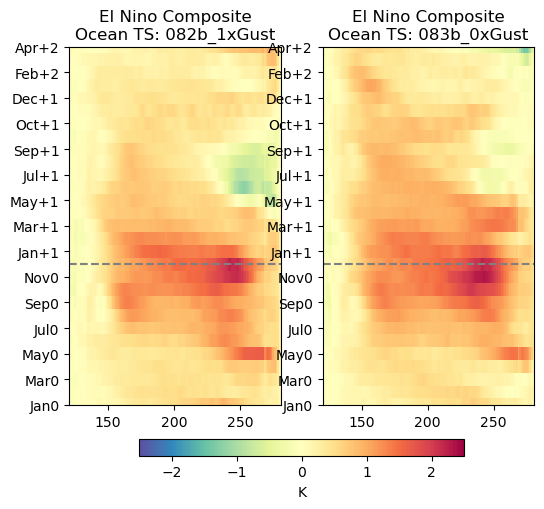

In [135]:
plotHovm_elnino('TS', matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5),'K')

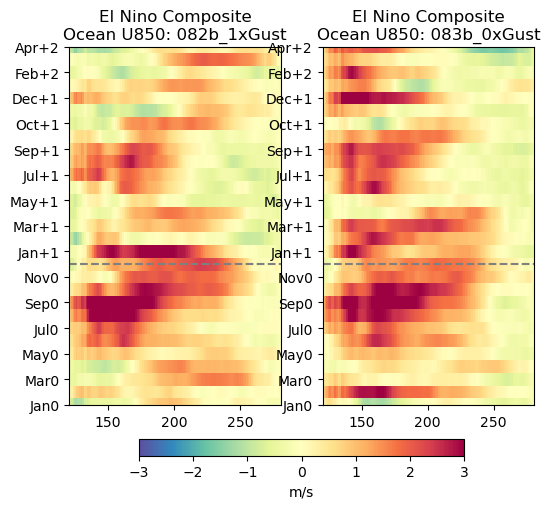

In [136]:
plotHovm_elnino('U850', matplotlib.colors.Normalize(vmin=-3,vmax=3), 'm/s')

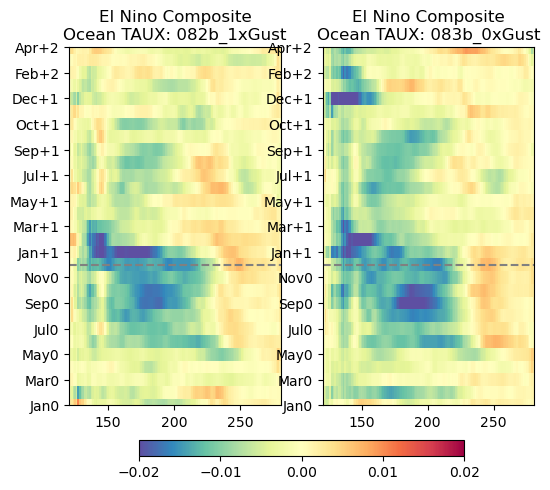

In [137]:
plotHovm_elnino('TAUX', matplotlib.colors.Normalize(vmin=-0.02,vmax=0.02), '')

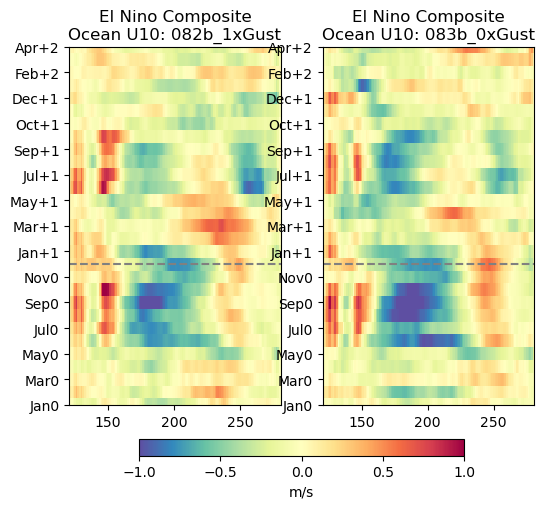

In [138]:
plotHovm_elnino('U10', matplotlib.colors.Normalize(vmin=-1,vmax=1), 'm/s')

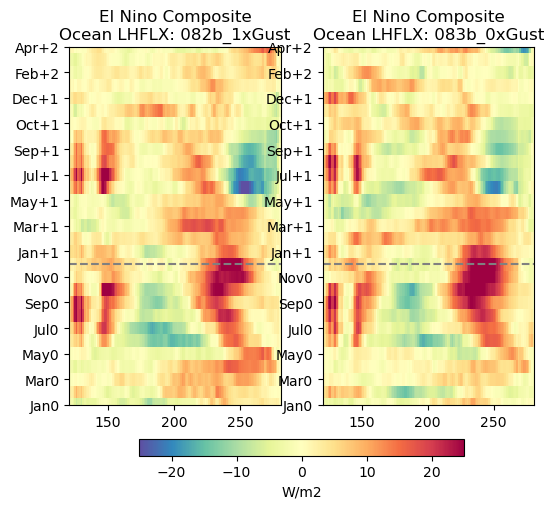

In [141]:
plotHovm_elnino('LHFLX', matplotlib.colors.Normalize(vmin=-25,vmax=25), 'W/m2')

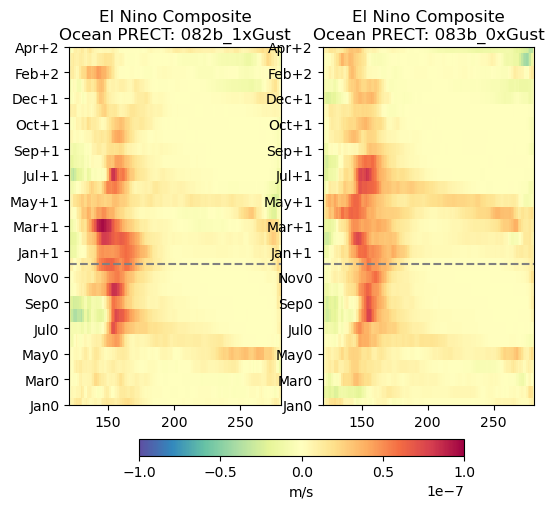

In [142]:
plotHovm_elnino('PRECT', matplotlib.colors.Normalize(vmin=-1e-7,vmax=1e-7), 'm/s')

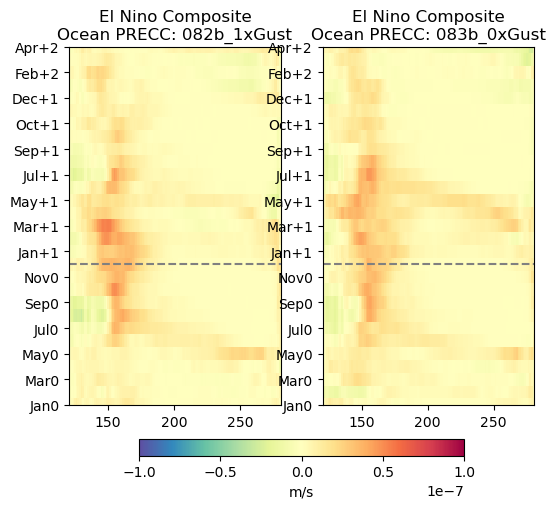

In [143]:
plotHovm_elnino('PRECC', matplotlib.colors.Normalize(vmin=-1e-7,vmax=1e-7), 'm/s')

In [84]:
# varSel = 'TS'
# varSel = 'TAUX'
varSel = 'U850'

    
# Compute anomaly over ocean only 
maskVar    = all_h0[varSel] * ocnMask

## Remove climatology from SST 
anom = rmMonAnnCyc_Var(maskVar)

## Limit range in lat/lon 
anom = anom.sel(lat=slice(-3,3), lon=slice(120,280))

## This is the empty array to fill with means... 
# fvar_hi = np.full([len(anom.case.values), 48, len(anom.lon.values)], np.nan)

## Take window around ENSO events 
cntr_hi  = np.zeros([len(anom.case.values)]) 
cntr_lo  = np.zeros([len(anom.case.values)]) 
cntr_mid = np.zeros([len(anom.case.values)]) 

for iCase in range(len(sstr.case.values)): 
# for iCase in range(1): 
    thisCase_nino = nino34_ndj.isel(case=iCase)
    thisCase_anom = anom.isel(case=iCase)

    for iYr in range(len(nino34_ndj.time.values)-1):
        # print(thisCase_nino.isel(time=iYr).time.values)
        # El Nino 
        if thisCase_nino.isel(time=iYr).values >=1: 
            iTime_all = np.where(anom.time.values == thisCase_nino.isel(time=iYr).time.values)[0]
            iTime_slice = np.arange(iTime_all-24, iTime_all+24)  ## Take a look 

            anom_slice         = thisCase_anom.isel(time=iTime_slice).mean(dim='lat').assign_coords({"eventNum": cntr_hi[iCase]})
            anom_slice['time'] = np.arange(-24,24)
            
            # Create new dimension (event) 
            if cntr_hi[iCase]==0:
                fvar_hi_case = anom_slice
            else: 
                fvar_hi_case = xr.concat([fvar_hi_case, anom_slice], "eventNum")
            
            cntr_hi[iCase] = cntr_hi[iCase] +1 
    if iCase==0:
        fvar_hi = fvar_hi_case.assign_coords({"case": thisCase_anom.case.values})
    else: 
        temp = fvar_hi_case.assign_coords({"case": thisCase_anom.case.values})
        fvar_hi = xr.concat([fvar_hi, temp], "case")


In [85]:
mean_high  = fvar_hi.mean(dim='eventNum')

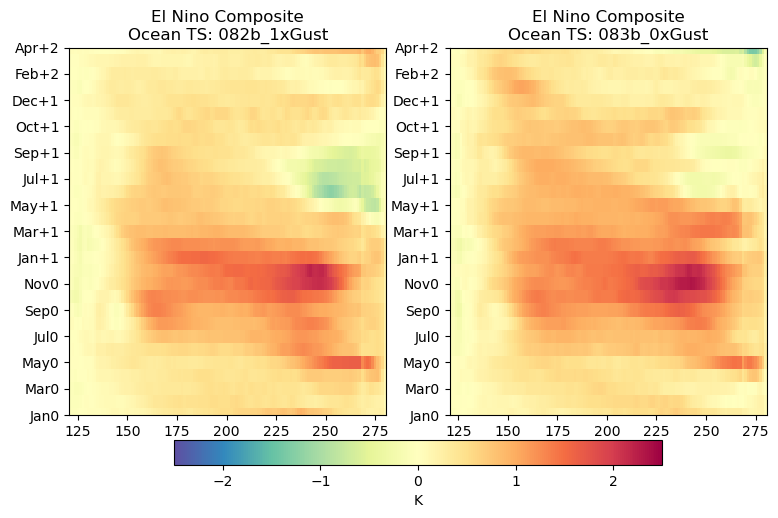

In [77]:
fig,axs = plt.subplots(1,2, figsize=(9,6))
axs     = axs.ravel()

longrid,tgrid  = np.meshgrid(mean_high['lon'], mean_high['time'] )

varNorm_high   = matplotlib.colors.Normalize(vmin=-2.5,vmax=2.5)

for iCase in range(len(fvar_hi.case.values)): 
    axs[iCase].set_title('El Nino Composite\nOcean '+varSel+': '+fvar_hi.case.values[iCase][8::]) 

    axs[iCase].pcolormesh(longrid,tgrid, mean_high.isel(case=iCase).values, norm=varNorm_high, cmap='Spectral_r')

[a.set_ylim([-11,17]) for a in axs]
[a.set_yticks(np.arange(-11,19,2)) for a in axs]

ytick_labels = ['Jan0','Mar0','May0','Jul0','Sep0','Nov0','Jan+1','Mar+1','May+1','Jul+1','Sep+1','Oct+1','Dec+1','Feb+2','Apr+2']
[a.set_yticklabels(ytick_labels) for a in axs]

# Add Colorbar
cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=varNorm_high, cmap='Spectral_r'), ax=axs, shrink=0.7, 
                      label='K', orientation='horizontal', pad=0.055) 

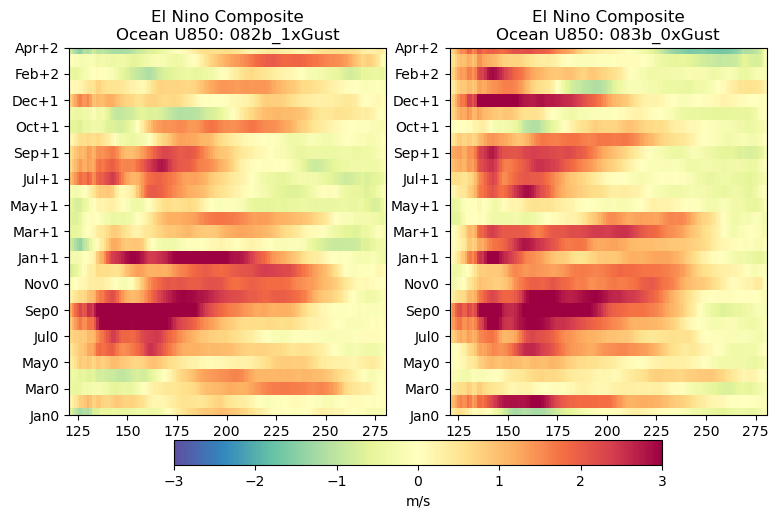

In [88]:
fig,axs = plt.subplots(1,2, figsize=(9,6))
axs     = axs.ravel()

longrid,tgrid  = np.meshgrid(mean_high['lon'], mean_high['time'] )

varNorm_high   = matplotlib.colors.Normalize(vmin=-3,vmax=3)

for iCase in range(len(fvar_hi.case.values)): 
    axs[iCase].set_title('El Nino Composite\nOcean '+varSel+': '+fvar_hi.case.values[iCase][8::]) 

    axs[iCase].pcolormesh(longrid,tgrid, mean_high.isel(case=iCase).values, norm=varNorm_high, cmap='Spectral_r')

[a.set_ylim([-11,17]) for a in axs]
[a.set_yticks(np.arange(-11,19,2)) for a in axs]

ytick_labels = ['Jan0','Mar0','May0','Jul0','Sep0','Nov0','Jan+1','Mar+1','May+1','Jul+1','Sep+1','Oct+1','Dec+1','Feb+2','Apr+2']
[a.set_yticklabels(ytick_labels) for a in axs]

# Add Colorbar
cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=varNorm_high, cmap='Spectral_r'), ax=axs, shrink=0.7, 
                      label='m/s', orientation='horizontal', pad=0.055) 


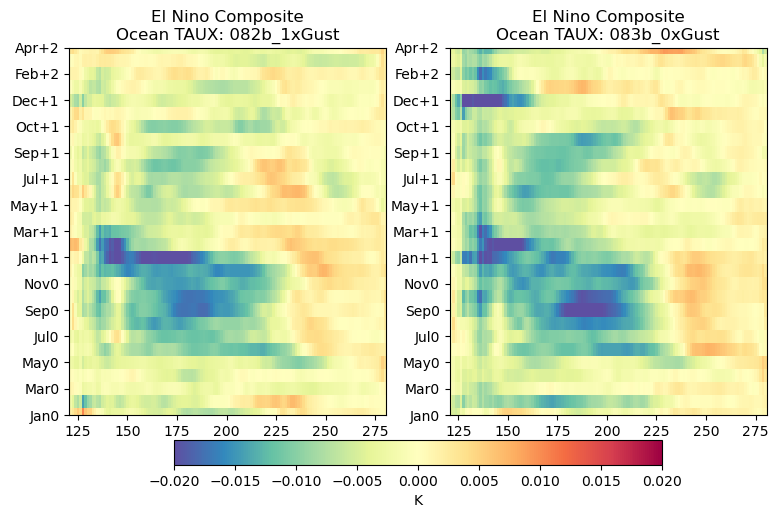

In [83]:
fig,axs = plt.subplots(1,2, figsize=(9,6))
axs     = axs.ravel()

longrid,tgrid  = np.meshgrid(mean_high['lon'], mean_high['time'] )

varNorm_high   = matplotlib.colors.Normalize(vmin=-0.02,vmax=0.02)

for iCase in range(len(fvar_hi.case.values)): 
    axs[iCase].set_title('El Nino Composite\nOcean '+varSel+': '+fvar_hi.case.values[iCase][8::]) 

    axs[iCase].pcolormesh(longrid,tgrid, mean_high.isel(case=iCase).values, norm=varNorm_high, cmap='Spectral_r')

[a.set_ylim([-11,17]) for a in axs]
[a.set_yticks(np.arange(-11,19,2)) for a in axs]

ytick_labels = ['Jan0','Mar0','May0','Jul0','Sep0','Nov0','Jan+1','Mar+1','May+1','Jul+1','Sep+1','Oct+1','Dec+1','Feb+2','Apr+2']
[a.set_yticklabels(ytick_labels) for a in axs]

# Add Colorbar
cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=varNorm_high, cmap='Spectral_r'), ax=axs, shrink=0.7, 
                      label='K', orientation='horizontal', pad=0.055) 


## Timeseries

Text(0.5, 1.0, 'Nino 3.4: BLT1850_083b_0xGust')

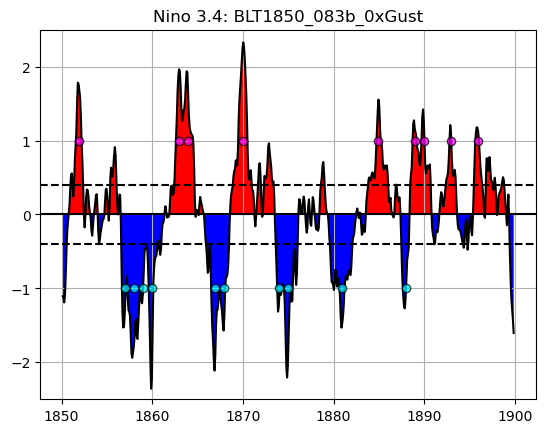

In [41]:
plt.plot(nino34.time.values, nino34.isel(case=1).values,'k')
plt.axhline(0, color='k')

plt.fill_between(nino34.time.values, 0, nino34.isel(case=1).values, 
                 where=nino34.isel(case=1).values >= 0, facecolor='red', interpolate=True)
plt.fill_between(nino34.time.values, nino34.isel(case=1).values, 0, 
                 where=nino34.isel(case=1).values <= 0, facecolor='blue', interpolate=True)



iDec = np.where(nino34['time.month'].values==12)[0]
for iPnt in range(len(iDec)): 
    if nino34.isel(case=1).values[iDec[iPnt]]>=1:
        plt.plot(nino34.time.values[iDec[iPnt]], 1, 'o',color='magenta',markeredgecolor='k',alpha=0.7)
    elif nino34.isel(case=1).values[iDec[iPnt]]<=-1:
        plt.plot(nino34.time.values[iDec[iPnt]], -1, 'o',color='cyan',markeredgecolor='k',alpha=0.7)

plt.axhline(0.4, color='k', linestyle='--')
plt.axhline(-0.4, color='k', linestyle='--')
plt.ylim([-2.5, 2.5])
plt.grid()

plt.title('Nino 3.4: '+str(nino34.isel(case=1).case.values))

In [69]:
## Taking a stab at 'central equatorial pacific) 
selDS = all_h0.sel(lat=slice(-2,2), lon=slice(190,205)).mean(dim='lat').mean(dim='lon')


In [73]:
# ## Plot timeseries of variables
# varSel = 'U850' 
# climoVar_U850 = weighted_temporal_mean(selDS, varSel).mean(dim='time').load()
# anomVar_U850 = (selDS[varSel] - climoVar_U850).rolling(time=3).mean()

varSel_TS   = 'TS' 
climoVar_TS = weighted_temporal_mean(selDS, varSel_TS).mean(dim='time').load()
anomVar_TS  = (selDS[varSel_TS] - climoVar_TS).rolling(time=3).mean()


In [72]:
## Plot timeseries of variables
varSel = 'U850' 
varAnom = rmMonAnnCyc(selDS,'U850')
# climoVar_U850 = weighted_temporal_mean(varAnom, varSel).mean(dim='time').load()
climoVar_U850 = varAnom.mean(dim='time').load()
anomVar_U850 = (selDS[varSel] - climoVar_U850).rolling(time=3).mean()

# varSel = 'TS' 
# varAnom = rmMonAnnCyc(selDS,'U850')
# climoVar_U850 = weighted_temporal_mean(varAnom, varSel).mean(dim='time').load()
# anomVar_U850 = (selDS[varSel] - climoVar_U850).rolling(time=3).mean()


In [ ]:
fig,axs = plt.subplots(3,1,figsize=(10,8))
axs = axs.ravel()

plt.gcf().text(0.45, 0.94,  anomVar_U850.isel(case=0).case.values, fontsize=14)

## Plot Nino 3.4 index
axs[0].plot(nino34.time.values, nino34.isel(case=0).values,'k')
axs[0].axhline(0, color='k')
axs[0].fill_between(nino34.time.values, 0, nino34.isel(case=0).values, 
                 where=nino34.isel(case=0).values >= 0, facecolor='red', interpolate=True)
axs[0].fill_between(nino34.time.values, nino34.isel(case=0).values, 0, 
                 where=nino34.isel(case=0).values <= 0, facecolor='blue', interpolate=True)
axs[0].axhline(0.4, color='k', linestyle='--')
axs[0].axhline(-0.4, color='k', linestyle='--')
axs[0].set_ylim([-2.5, 2.5])
axs[0].grid()
axs[0].set_title('Nino 3.4: '+str(nino34.isel(case=0).case.values))


axs[1].plot(anomVar_U850.time.values, anomVar_U850.isel(case=0).values,'b')
axs[1].axhline(0, color='k')
axs[1].grid()
axs[1].set_title('U850 Anomalies (3 month running mean)')


axs[2].plot(anomVar_TS.time.values, anomVar_TS.isel(case=0).values,'b')
axs[2].axhline(0, color='k')
axs[2].grid()
axs[2].set_title('TS Anomalies (3 month running mean)')



In [ ]:
fig,axs = plt.subplots(3,1,figsize=(10,8))
axs = axs.ravel()

plt.gcf().text(0.45, 0.94,  anomVar.isel(case=2).case.values, fontsize=14)

## Plot Nino 3.4 index
axs[0].plot(nino34.time.values, nino34.isel(case=2).values,'k')
axs[0].axhline(0, color='k')
axs[0].fill_between(nino34.time.values, 0, nino34.isel(case=2).values, 
                 where=nino34.isel(case=2).values >= 0, facecolor='red', interpolate=True)
axs[0].fill_between(nino34.time.values, nino34.isel(case=2).values, 0, 
                 where=nino34.isel(case=2).values <= 0, facecolor='blue', interpolate=True)
axs[0].axhline(0.4, color='k', linestyle='--')
axs[0].axhline(-0.4, color='k', linestyle='--')
axs[0].set_ylim([-2.5, 2.5])
axs[0].grid()
axs[0].set_title('Nino 3.4: '+str(nino34.isel(case=2).case.values))


axs[1].plot(anomVar_U850.time.values, anomVar_U850.isel(case=2).values,'b')
axs[1].axhline(0, color='k')
axs[1].grid()
axs[1].set_title('U850 Anomalies (3 month running mean)')


axs[2].plot(anomVar_TS.time.values, anomVar_TS.isel(case=2).values,'b')
axs[2].axhline(0, color='k')
axs[2].grid()
axs[2].set_title('TS Anomalies (3 month running mean)')



## Averages for each phase of ENSO

In [155]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [228]:
longrid, latgrid = np.meshgrid(all_h0['lon'], all_h0['lat'].sel(lat=slice(-25,25)) )


In [26]:
# ocnMask = all_h0.OCNFRAC.isel(time=0).values
# ocnMask[ocnMask==0] = np.nan

In [229]:
def plotCompositeAnomalies(varSel, unitsStr, selMin, selMax):
    fig,axs = plt.subplots(2,4,figsize=(15,2), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()

    varAnom        = rmMonAnnCyc(all_h0, varSel)
    all_h0_ElNino  =  varAnom.where(all_h0['ENSO_phase'] == 'ElNino')
    all_h0_LaNina  =  varAnom.where(all_h0['ENSO_phase'] == 'LaNina')
    all_h0_Neutral =  varAnom.where(all_h0['ENSO_phase'] == 'Neutral')
    
    avgWgtVar_climo   = weighted_temporal_mean(all_h0[varSel]).mean(dim='time').load() *  ocnMask[:,0,:,:] # ann mean returned, need to avg years
    avgWgtVar_ElNino  = weighted_temporal_mean(all_h0_ElNino).mean(dim='time').load() *  ocnMask[:,0,:,:] # Select single time of ocnMask
    avgWgtVar_LaNina  = weighted_temporal_mean(all_h0_LaNina).mean(dim='time').load() *  ocnMask[:,0,:,:]
    avgWgtVar_Neutral = weighted_temporal_mean(all_h0_Neutral).mean(dim='time').load() *  ocnMask[:,0,:,:]
    
    # anom_ElNino  = (avgWgtVar_ElNino-avgWgtVar_climo).sel(lat=slice(-25,25))
    # anom_LaNina  = (avgWgtVar_LaNina-avgWgtVar_climo).sel(lat=slice(-25,25))
    # anom_Neutral = (avgWgtVar_Neutral-avgWgtVar_climo).sel(lat=slice(-25,25))
        
    anom_ElNino  = (avgWgtVar_ElNino).sel(lat=slice(-25,25))
    anom_LaNina  = (avgWgtVar_LaNina).sel(lat=slice(-25,25))
    anom_Neutral = (avgWgtVar_Neutral).sel(lat=slice(-25,25))
    
    # diffMax  = np.nanmax([np.nanmax(np.abs(anom_ElNino)), np.nanmax(np.abs(anom_LaNina)), np.nanmax(np.abs(anom_Neutral))])*0.8
    # var_norm = matplotlib.colors.Normalize(vmin=-diffMax, vmax=diffMax)

    diffLim_ElNino = np.nanmax(np.abs(anom_ElNino)) * 0.85
    var_normElNino = matplotlib.colors.Normalize(vmin=-diffLim_ElNino, vmax=diffLim_ElNino)

    diffLim_LaNina = np.nanmax(np.abs(anom_LaNina)) * 0.85
    var_normLaNina = matplotlib.colors.Normalize(vmin=-diffLim_LaNina, vmax=diffLim_LaNina)

    diffLim_Neutral = np.nanmax(np.abs(anom_Neutral)) * 0.85
    var_normNeutral = matplotlib.colors.Normalize(vmin=-diffLim_Neutral, vmax=diffLim_Neutral)

    var_normClimo   = matplotlib.colors.Normalize(vmin=selMin, 
                                                  vmax=selMax, )
    
    for iCase in range(len(all_h0.case.values)):
        axs[4*iCase].pcolormesh(longrid, latgrid, anom_ElNino.isel(case=iCase).values, 
                                   transform=ccrs.PlateCarree(), norm=var_normElNino, cmap='Spectral_r') 
        axs[1 + (4*iCase)].pcolormesh(longrid, latgrid, anom_LaNina.isel(case=iCase).values, 
                                   transform=ccrs.PlateCarree(), norm=var_normLaNina, cmap='Spectral_r') 
        axs[2 + (4*iCase)].pcolormesh(longrid, latgrid, anom_Neutral.isel(case=iCase).values, 
                                   transform=ccrs.PlateCarree(), norm=var_normNeutral, cmap='Spectral_r') 
        axs[3 + (4*iCase)].pcolormesh(longrid, latgrid, avgWgtVar_climo.isel(case=iCase).sel(lat=slice(-25,25)).values, 
                                   transform=ccrs.PlateCarree(), norm=var_normClimo, cmap='rainbow') 
        
        plt.gcf().text(0.03, 0.7-(iCase*0.35), str(anom_ElNino.isel(case=iCase).case.values)[8::], fontsize=14)

        if iCase==(len(all_h0.case.values) - 1):
            cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_normElNino, cmap='Spectral_r'), ax=axs[4*iCase], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 

            cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_normLaNina, cmap='Spectral_r'), ax=axs[1 + (4*iCase)], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 
            
            cb3 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_normNeutral, cmap='Spectral_r'), ax=axs[2 + (4*iCase)], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 

            cb4 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_normClimo, cmap='rainbow'), ax=axs[3 + (4*iCase)], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 
    
    # cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='seismic'), ax=axs, shrink=0.5, 
    #                   label=unitsStr, orientation='horizontal', pad=0.025) 

        ## Add CVDP box? 
        # axs[4*iCase].add_patch(patches.Rectangle(xy=[120, -3], width=160, height=6,
        #                         facecolor='none', edgecolor='k',
        #                         linewidth=1, transform=ccrs.PlateCarree()))
    
    axs[1].set_title(varSel+' Anomaly', fontsize=14)
    [a.coastlines() for a in axs]
    # [a.set_extent([2,358,-15,15]) for a in axs]
    # [a.set_extent([30,263,-25,25], crs=ccrs.PlateCarree()) for a in axs]
    [a.set_extent([65,285,-25,25], crs=ccrs.PlateCarree()) for a in axs]
    
    plt.gcf().text(0.15, 0.95, 'El Nino Composite', fontsize=14)
    plt.gcf().text(0.35, 0.95,  'La Nina Composite', fontsize=14)
    plt.gcf().text(0.55, 0.95, 'Neutral Composite', fontsize=14)
    plt.gcf().text(0.78, 0.95, 'Climatology', fontsize=14)
    
    plt.show()
    
    return 

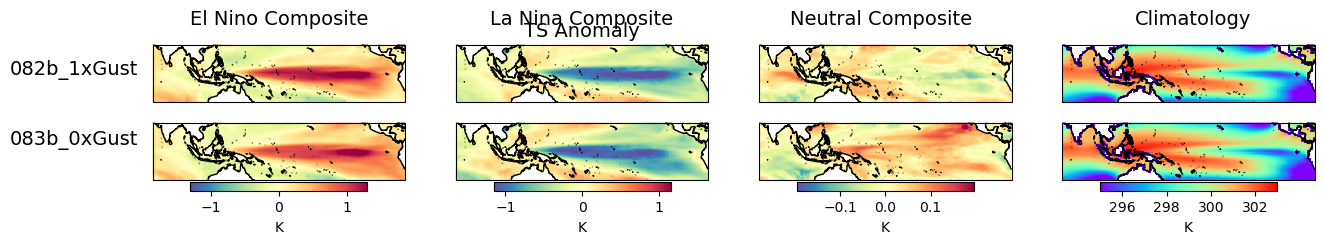

In [194]:
plotCompositeAnomalies('TS', 'K', 295, 303)

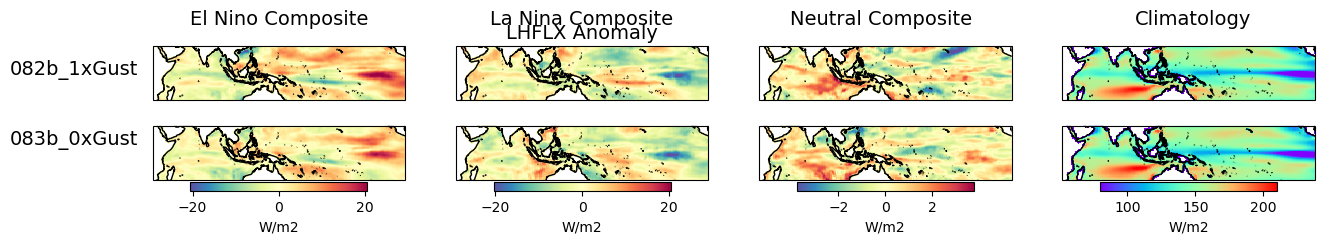

In [174]:
plotCompositeAnomalies('LHFLX', 'W/m2', 80, 210)

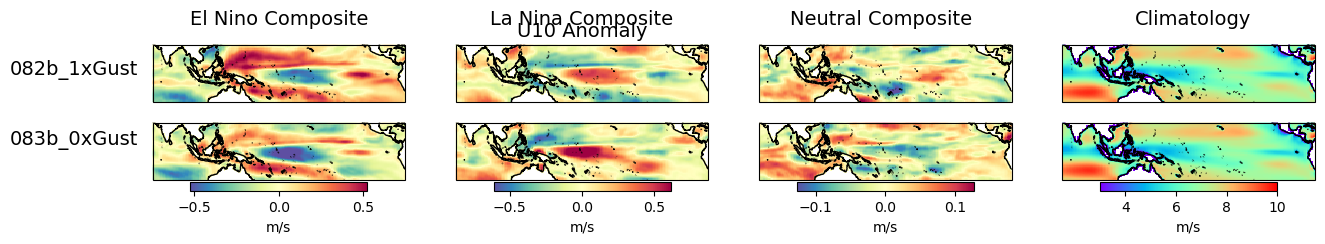

In [231]:
plotCompositeAnomalies('U10', 'm/s', 3, 10)

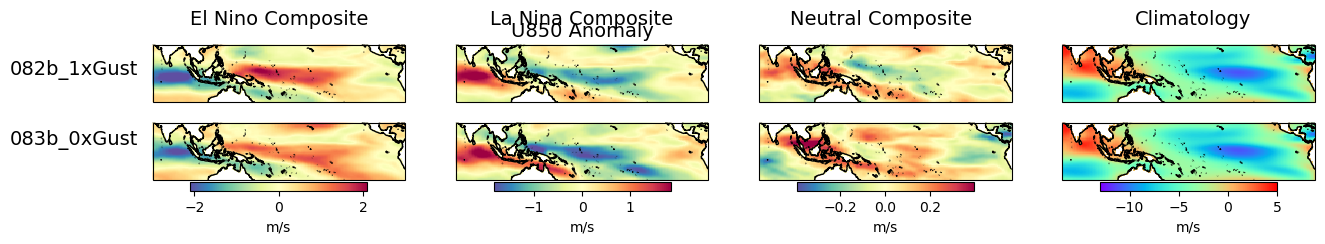

In [195]:
plotCompositeAnomalies('U850', 'm/s', -13, 5)

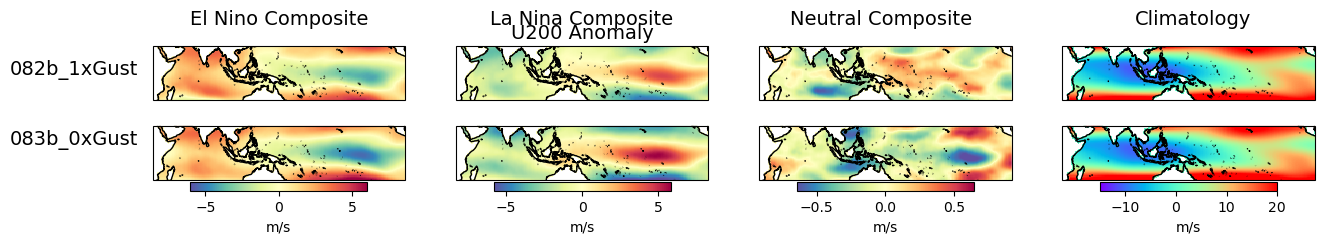

In [178]:
plotCompositeAnomalies('U200', 'm/s', -15, 20)

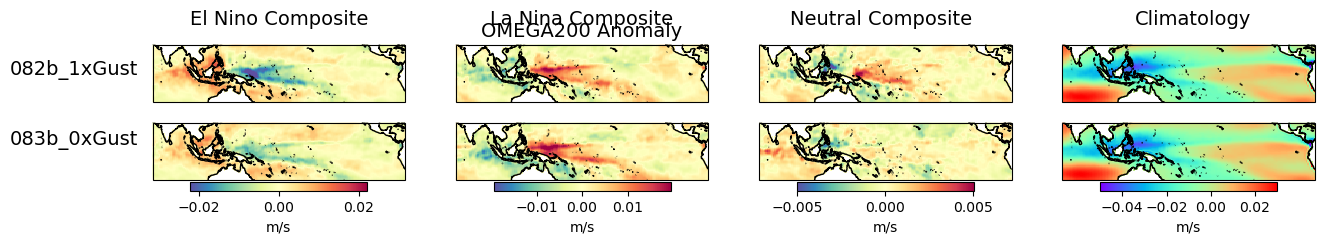

In [206]:
plotCompositeAnomalies('OMEGA200', 'm/s', -0.05, 0.03)

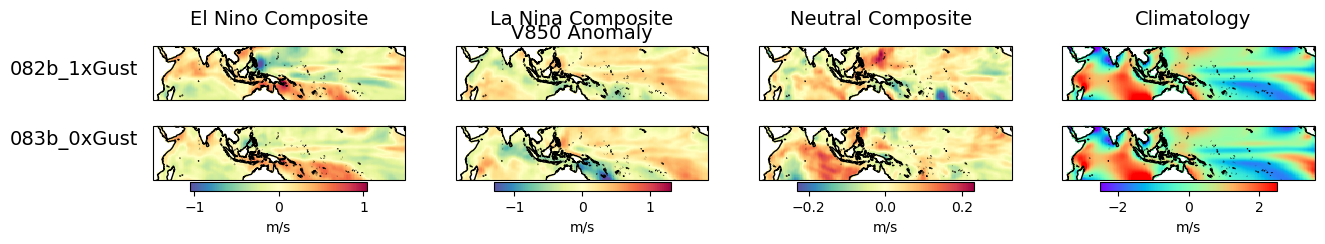

In [180]:
plotCompositeAnomalies('V850', 'm/s',-2.5,2.5)

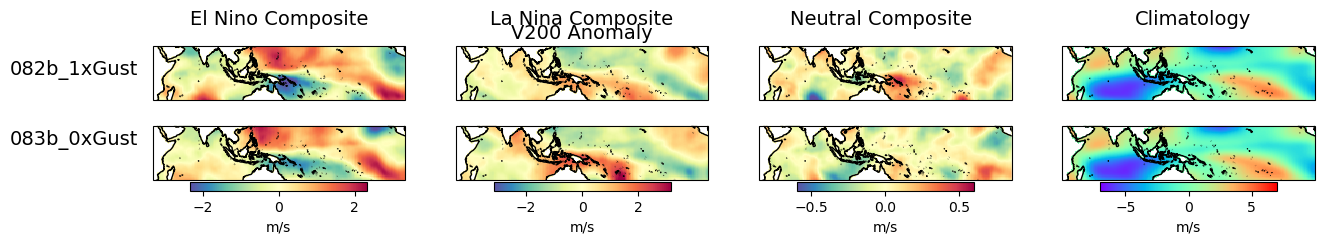

In [181]:
plotCompositeAnomalies('V200', 'm/s',-7,7)

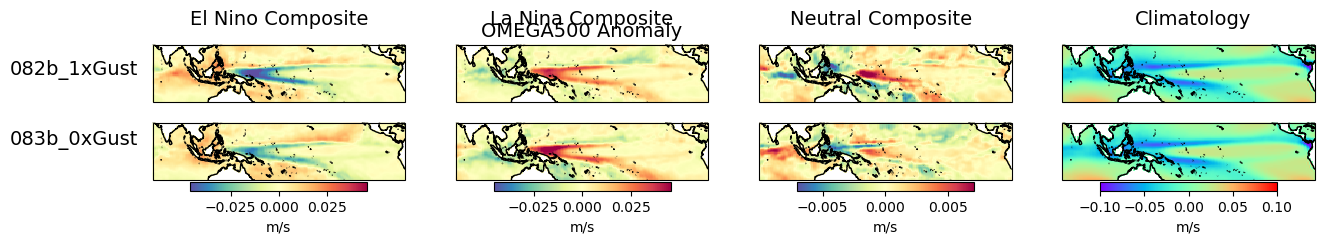

In [207]:
plotCompositeAnomalies('OMEGA500', 'm/s',-0.1, 0.1)

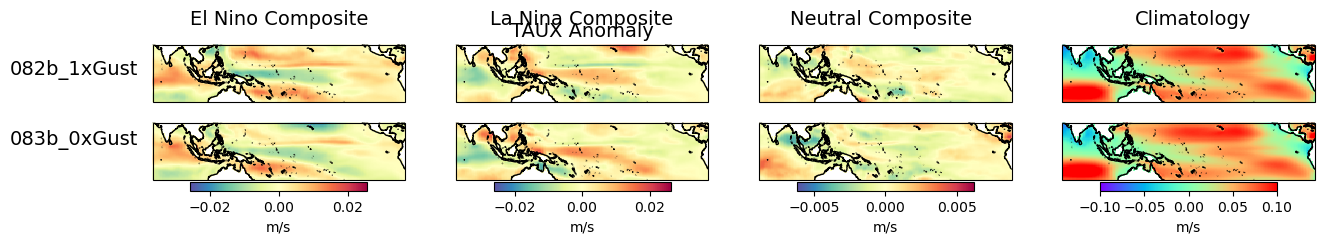

In [230]:
plotCompositeAnomalies('TAUX', 'm/s',-0.1, 0.1)

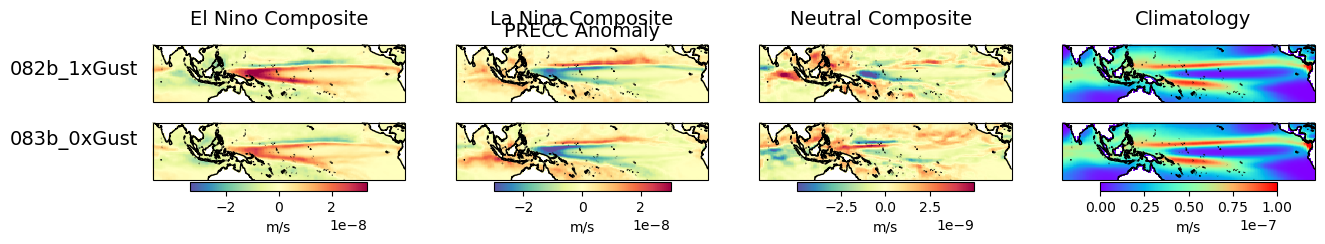

In [208]:
plotCompositeAnomalies('PRECC', 'm/s', 0, 1e-7)

**Plot cross section composites**

In [211]:
longrid, levgrid = np.meshgrid(all_h0['lon'], all_h0['lev']) 


In [218]:
ocnMask = all_h0.OCNFRAC.isel(time=0).values
ocnMask[ocnMask==0] = np.nan
ocnMaskLev = np.full([len(all_h0.case.values), len(all_h0.lev.values), len(all_h0.lat.values), len(all_h0.lon.values)], np.nan)

for iLev in range(len(all_h0.lev.values)):
    ocnMaskLev[:,iLev,:,:] = ocnMask


In [219]:
def plotCompositeAnomalies_VerticalCross(varSel, unitsStr):
    fig,axs = plt.subplots(3,4,figsize=(19,8))
    axs     = axs.ravel()
    
    varAnom        = rmMonAnnCyc(all_h0, varSel)
    all_h0_ElNino  =  varAnom.where(all_h0['ENSO_phase'] == 'ElNino')
    all_h0_LaNina  =  varAnom.where(all_h0['ENSO_phase'] == 'LaNina')
    all_h0_Neutral =  varAnom.where(all_h0['ENSO_phase'] == 'Neutral')
    
    avgWgtVar_climo   = weighted_temporal_mean(all_h0[varSel]).mean(dim='time').load() *  ocnMaskLev # ann mean returned, need to avg years
    avgWgtVar_ElNino  = weighted_temporal_mean(all_h0_ElNino).mean(dim='time').load() *  ocnMaskLev # Select single time of ocnMask
    avgWgtVar_LaNina  = weighted_temporal_mean(all_h0_LaNina).mean(dim='time').load() *  ocnMaskLev
    avgWgtVar_Neutral = weighted_temporal_mean(all_h0_Neutral).mean(dim='time').load() *  ocnMaskLev

    
    # avgWgtVar_climo   = weighted_temporal_mean(all_h0, varSel).mean(dim='time').load() * ocnMask # ann mean returned, need to avg years
    # avgWgtVar_ElNino  = weighted_temporal_mean(all_h0_ElNino, varSel).mean(dim='time').load() * ocnMask
    # avgWgtVar_LaNina  = weighted_temporal_mean(all_h0_LaNina, varSel).mean(dim='time').load() * ocnMask
    # avgWgtVar_Neutral = weighted_temporal_mean(all_h0_Neutral, varSel).mean(dim='time').load() * ocnMask
    
    slice_ElNino = (avgWgtVar_ElNino).sel(lat=slice(-5,5)).mean(dim='lat')
    slice_LaNina = (avgWgtVar_LaNina).sel(lat=slice(-5,5)).mean(dim='lat')
    slice_Neutral = (avgWgtVar_Neutral).sel(lat=slice(-5,5)).mean(dim='lat')
    slice_climo   = (avgWgtVar_climo).sel(lat=slice(-5,5)).mean(dim='lat')    
    
    valMax  = np.nanmax([np.nanmax(np.abs(slice_ElNino)), np.nanmax(np.abs(slice_LaNina)), 
                          np.nanmax(np.abs(slice_Neutral)), np.nanmax(np.abs(slice_climo))])*0.8
    var_norm = matplotlib.colors.Normalize(vmin=-valMax, vmax=valMax)

     
    for iCase in range(len(all_h0.case.values)):
        axs[4*iCase].pcolormesh(longrid, levgrid, slice_ElNino.isel(case=iCase).values, 
                                   norm=var_norm, cmap='PiYG') 
        axs[1 + (4*iCase)].pcolormesh(longrid, levgrid, slice_LaNina.isel(case=iCase).values, 
                                   norm=var_norm, cmap='PiYG') 
        axs[2 + (4*iCase)].pcolormesh(longrid, levgrid, slice_Neutral.isel(case=iCase).values, 
                                      norm=var_norm, cmap='PiYG') 
        axs[3 + (4*iCase)].pcolormesh(longrid, levgrid, slice_climo.isel(case=iCase).values, 
                                      norm=var_norm, cmap='PiYG') 
        
        plt.gcf().text(0.03, 0.78-(iCase*0.26), str(slice_ElNino.isel(case=iCase).case.values)[8::], fontsize=14)

        if iCase==(len(all_h0.case.values) - 1):
            cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='PiYG'), ax=axs[4*iCase], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 

            cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='PiYG'), ax=axs[1 + (4*iCase)], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 
            
            cb3 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='PiYG'), ax=axs[2 + (4*iCase)], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 
            
            cb4 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='PiYG'), ax=axs[3+ + (4*iCase)], shrink=0.7, 
                      label=unitsStr, orientation='horizontal', pad=0.025) 
    
    # cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='seismic'), ax=axs, shrink=0.5, 
    #                   label=unitsStr, orientation='horizontal', pad=0.025) 

    
    
    axs[1].set_title(varSel+' (Mean of 5S-5N)', fontsize=14)
    [a.set_ylim([1000,200]) for a in axs]
    [a.set_xlim([35,200]) for a in axs]
    # [a.coastlines() for a in axs]
    # [a.set_extent([2,358,-15,15]) for a in axs]
    # [a.set_extent([30,258,-25,25], crs=ccrs.PlateCarree()) for a in axs]
    
    plt.gcf().text(0.15, 0.94, 'El Nino Composite', fontsize=14)
    plt.gcf().text(0.35, 0.94,  'La Nina Composite', fontsize=14)
    plt.gcf().text(0.55, 0.94, 'Neutral Composite', fontsize=14)
    plt.gcf().text(0.77, 0.94, 'Climatology', fontsize=14)
    
    plt.show()
    
    return 

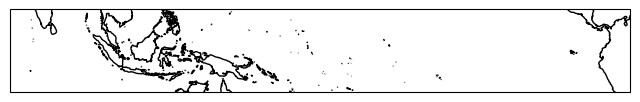

In [223]:
fig,axs = plt.subplots(1,1,figsize=(8,2), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs.coastlines()
axs.set_extent([65,290,-15,15], crs=ccrs.PlateCarree())

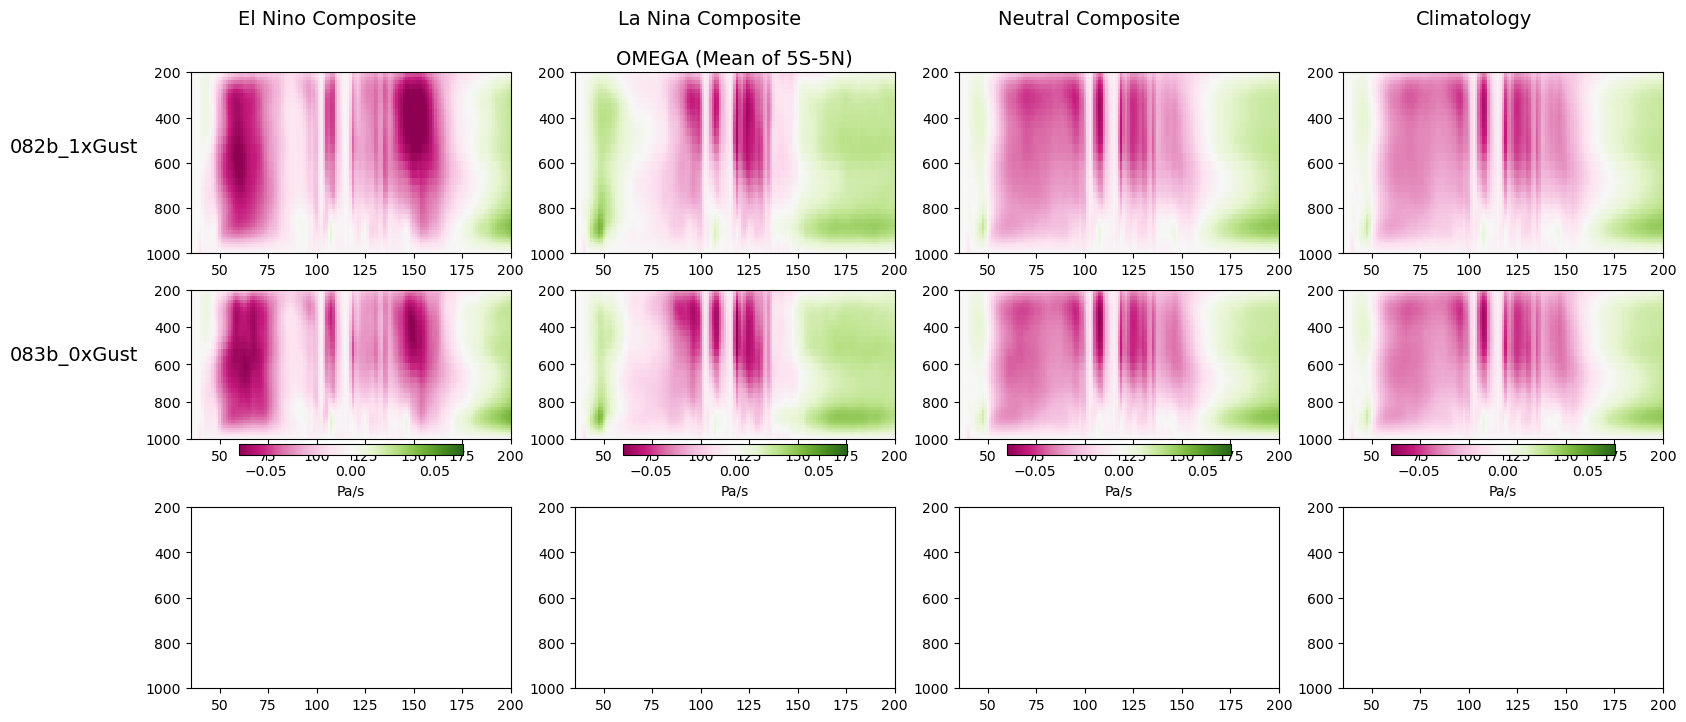

In [32]:
plotCompositeAnomalies_VerticalCross('OMEGA', all_h0.OMEGA.units)

In [214]:
all_h0_ElNino

<xarray.DataArray 'OMEGA' (case: 2, time: 600, lev: 58, lat: 192, lon: 288)>
dask.array<where, shape=(2, 600, 58, 192, 288), dtype=float32, chunksize=(1, 1, 58, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * lev      (lev) float64 3.018 5.445 9.087 14.25 ... 974.5 983.2 991.2 997.5
  * time     (time) datetime64[ns] 1850-01-15 1850-02-15 ... 1899-12-15
  * case     (case) <U19 'BLT1850_082b_1xGust' 'BLT1850_083b_0xGust'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [215]:
ocnMask = all_h0.OCNFRAC.isel(time=0).values
ocnMask[ocnMask==0] = np.nan

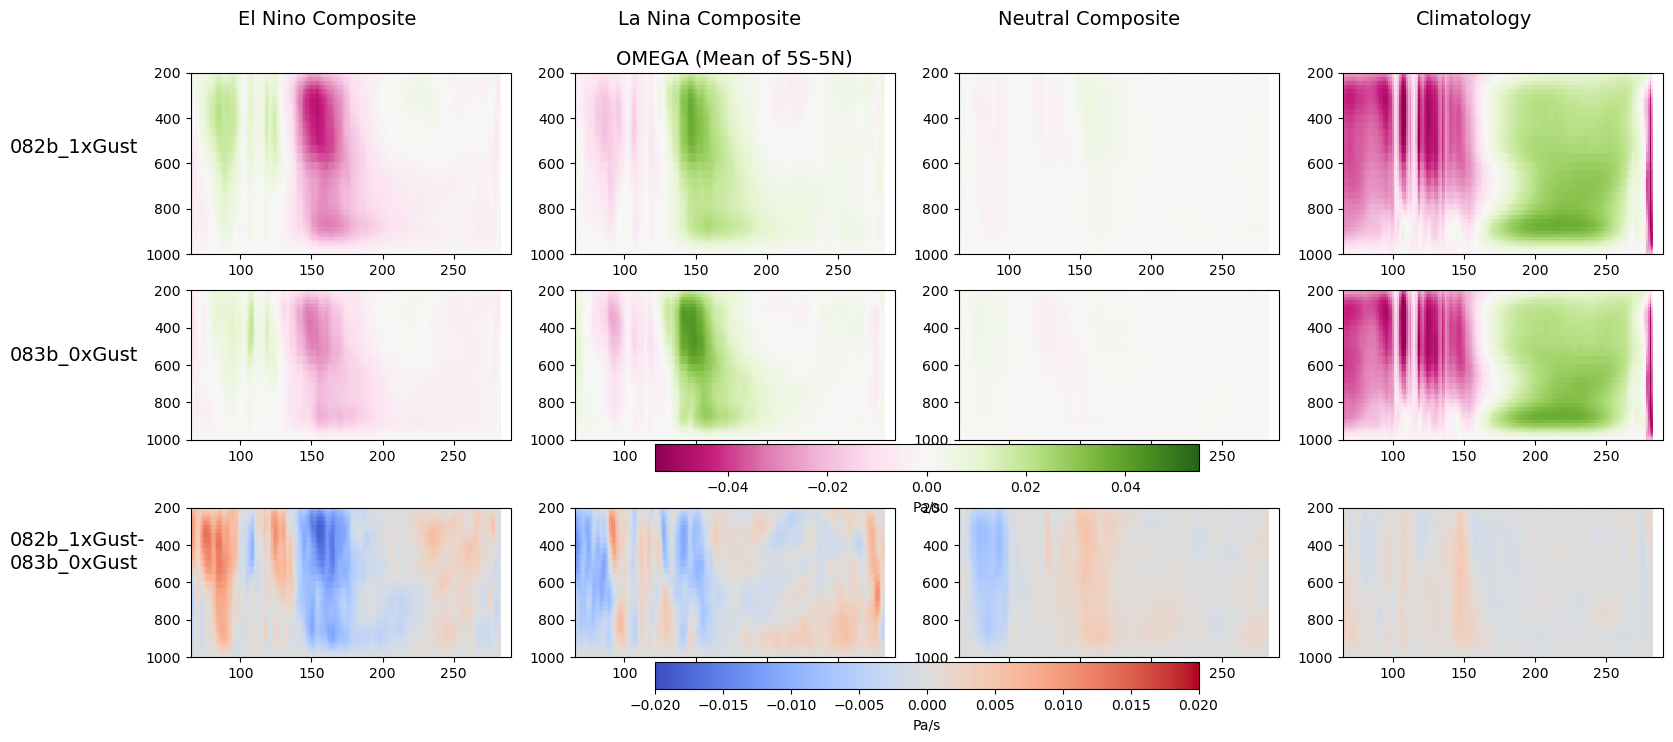

In [221]:
varSel = 'OMEGA'
unitsStr = all_h0.OMEGA.units


fig,axs = plt.subplots(3,4,figsize=(19,8))
axs     = axs.ravel()

# avgWgtVar_climo   = weighted_temporal_mean(all_h0, varSel).mean(dim='time').load() * ocnMask # ann mean returned, need to avg years
# avgWgtVar_ElNino  = weighted_temporal_mean(all_h0_ElNino, varSel).mean(dim='time').load() * ocnMask
# avgWgtVar_LaNina  = weighted_temporal_mean(all_h0_LaNina, varSel).mean(dim='time').load() * ocnMask
# avgWgtVar_Neutral = weighted_temporal_mean(all_h0_Neutral, varSel).mean(dim='time').load() * ocnMask

varAnom        = rmMonAnnCyc(all_h0, varSel)
all_h0_ElNino  =  varAnom.where(all_h0['ENSO_phase'] == 'ElNino')
all_h0_LaNina  =  varAnom.where(all_h0['ENSO_phase'] == 'LaNina')
all_h0_Neutral =  varAnom.where(all_h0['ENSO_phase'] == 'Neutral')

avgWgtVar_climo   = weighted_temporal_mean(all_h0[varSel]).mean(dim='time').load() *  ocnMaskLev # ann mean returned, need to avg years
avgWgtVar_ElNino  = weighted_temporal_mean(all_h0_ElNino).mean(dim='time').load() *  ocnMaskLev  # Select single time of ocnMask
avgWgtVar_LaNina  = weighted_temporal_mean(all_h0_LaNina).mean(dim='time').load() *  ocnMaskLev
avgWgtVar_Neutral = weighted_temporal_mean(all_h0_Neutral).mean(dim='time').load() *  ocnMaskLev
    
slice_ElNino = (avgWgtVar_ElNino).sel(lat=slice(-5,5)).mean(dim='lat')
slice_LaNina = (avgWgtVar_LaNina).sel(lat=slice(-5,5)).mean(dim='lat')
slice_Neutral = (avgWgtVar_Neutral).sel(lat=slice(-5,5)).mean(dim='lat')
slice_climo   = (avgWgtVar_climo).sel(lat=slice(-5,5)).mean(dim='lat')    

valMax  = np.nanmax([np.nanmax(np.abs(slice_ElNino)), np.nanmax(np.abs(slice_LaNina)), 
                      np.nanmax(np.abs(slice_Neutral)), np.nanmax(np.abs(slice_climo))])*0.8
var_norm = matplotlib.colors.Normalize(vmin=-valMax, vmax=valMax)

 
for iCase in range(len(all_h0.case.values)):
    axs[4*iCase].pcolormesh(longrid, levgrid, slice_ElNino.isel(case=iCase).values, 
                               norm=var_norm, cmap='PiYG') 
    axs[1 + (4*iCase)].pcolormesh(longrid, levgrid, slice_LaNina.isel(case=iCase).values, 
                               norm=var_norm, cmap='PiYG') 
    axs[2 + (4*iCase)].pcolormesh(longrid, levgrid, slice_Neutral.isel(case=iCase).values, 
                                  norm=var_norm, cmap='PiYG') 
    axs[3 + (4*iCase)].pcolormesh(longrid, levgrid, slice_climo.isel(case=iCase).values, 
                                  norm=var_norm, cmap='PiYG') 
    
    plt.gcf().text(0.03, 0.78-(iCase*0.26), str(slice_ElNino.isel(case=iCase).case.values)[8::], fontsize=14)

    if iCase==(len(all_h0.case.values) - 1):
        cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='PiYG'), ax=axs[0 + (4*iCase):4+(4*iCase)], shrink=0.7, 
                  label=unitsStr, orientation='horizontal', pad=0.025) 
        # cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs[0:2], shrink=0.5, 
        #               label='variance (m2/s2)', orientation='vertical', pad=0.025) 
        
## also plot the difference in the two cases in bottom row 
diff_norm = matplotlib.colors.Normalize(vmin=-0.02, vmax=0.02)

axs[8].pcolormesh(longrid, levgrid, slice_ElNino.isel(case=0).values - slice_ElNino.isel(case=1).values, 
                           norm=diff_norm, cmap='coolwarm') 
axs[9].pcolormesh(longrid, levgrid, slice_LaNina.isel(case=0).values - slice_LaNina.isel(case=1).values, 
                           norm=diff_norm, cmap='coolwarm') 
axs[10].pcolormesh(longrid, levgrid, slice_Neutral.isel(case=0).values - slice_Neutral.isel(case=1).values, 
                              norm=diff_norm, cmap='coolwarm') 
axs[11].pcolormesh(longrid, levgrid, slice_climo.isel(case=0).values - slice_climo.isel(case=1).values, 
                              norm=diff_norm, cmap='coolwarm') 

cb3 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap='coolwarm'), ax=axs[8::], shrink=0.7, 
                  label=unitsStr, orientation='horizontal', pad=0.025) 

plt.gcf().text(0.03, 0.78-(2*0.26), str(slice_ElNino.isel(case=0).case.values)[8::]+'-\n'+str(slice_ElNino.isel(case=1).case.values)[8::], fontsize=14)

axs[1].set_title(varSel+' (Mean of 5S-5N)', fontsize=14)
[a.set_ylim([1000,200]) for a in axs]
# [a.set_xlim([35,200]) for a in axs]
[a.set_xlim([65,290]) for a in axs]

plt.gcf().text(0.15, 0.94, 'El Nino Composite', fontsize=14)
plt.gcf().text(0.35, 0.94,  'La Nina Composite', fontsize=14)
plt.gcf().text(0.55, 0.94, 'Neutral Composite', fontsize=14)
plt.gcf().text(0.77, 0.94, 'Climatology', fontsize=14)

plt.show()


## Conditions that lead into and cover start of each phase?

In [34]:
## Step 1: Pick a variable and compute the anomalies from climatology 

ilats = np.where((all_h0.lat.values>=-5)  & (all_h0.lat.values<=5))[0]
ilons = np.where((all_h0.lon.values>=140) & (all_h0.lon.values<=280))[0]

varSel = 'TS'

regionTS = all_h0[varSel].isel(lat=ilats, lon=ilons) * all_h0.OCNFRAC.isel(lat=ilats, lon=ilons)
climoTS  = regionTS.mean(dim='time')

anomVar = (regionTS - climoTS).rolling(time=5).mean()

Text(0.5, 1.0, 'Nino 3.4 index: El Nino Events')

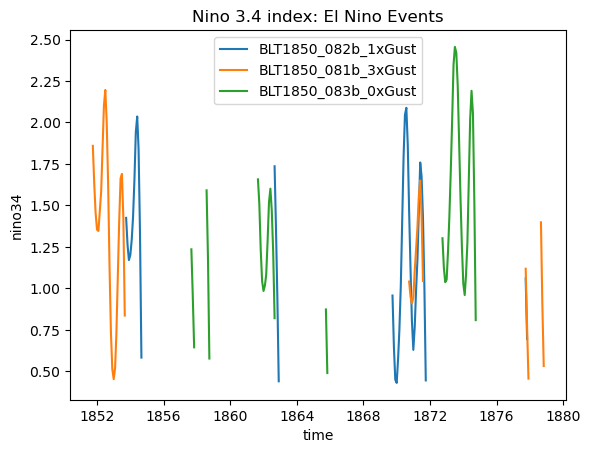

In [116]:
## For reference - El Nino events in each case
all_h0_ElNino.isel(case=0).nino34.plot()
all_h0_ElNino.isel(case=1).nino34.plot()
all_h0_ElNino.isel(case=2).nino34.plot()
plt.legend([str(all_h0_ElNino.isel(case=0).case.values),
            str(all_h0_ElNino.isel(case=1).case.values), 
            str(all_h0_ElNino.isel(case=2).case.values)])
plt.title('Nino 3.4 index: El Nino Events')


Text(0.5, 1.0, 'Nino 3.4 index: La Nina Events')

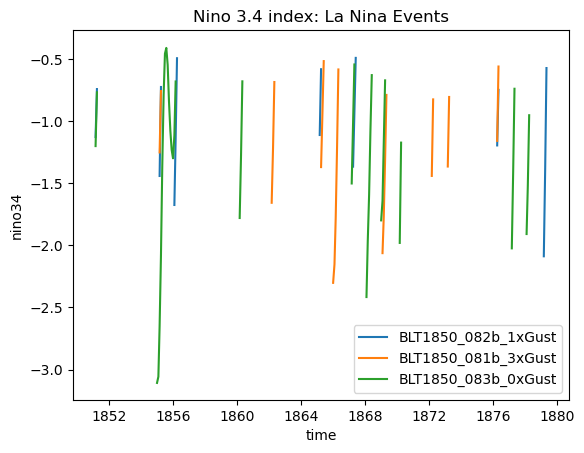

In [117]:
## For reference - El Nino events in each case
all_h0_LaNina.isel(case=0).nino34.plot()
all_h0_LaNina.isel(case=1).nino34.plot()
all_h0_LaNina.isel(case=2).nino34.plot()
plt.legend([str(all_h0_LaNina.isel(case=0).case.values),
            str(all_h0_LaNina.isel(case=1).case.values), 
            str(all_h0_LaNina.isel(case=2).case.values)])
plt.title('Nino 3.4 index: La Nina Events')


In [25]:
## Step 2: Identify start indices of each El Nino event 
iValid = np.where(np.isfinite(all_h0_ElNino.isel(case=0).nino34.values))[0]

iStarts_case0 = [iValid[0]]
for t in range(1, len(iValid)-1):
    if iValid[t] != iValid[t-1]+1:
        iStarts_case0 = np.append(iStarts_case0, iValid[t])
        
print(iStarts_case0)

In [53]:
## Step 3: Isolate 8 months around the start of each event - 6 months prior and two months in beginning of El Nino event

# Case 0 
DS                = anomVar.isel(case=0)
allElNinos_case0  = np.full([len(iStarts_case0), 12, len(anomVar.lat.values), len(anomVar.lon.values)], np.nan)

for iEvent in range(len(iStarts_case0)):
    startTime = iStarts_case0[iEvent]
    allElNinos_case0[iEvent,:,:,:] = DS.isel(time=np.arange(startTime-6, startTime+4)).values

    

ValueError: could not broadcast input array from shape (10,10,113) into shape (12,10,113)

In [ ]:
## Step 4: Average over all the events in a case
mean_ElNinos = np.nanmean(allElNinos_case0, 0)


In [ ]:
# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(anomVar.lat.values))
avg_data = np.sum((mean_ElNinos * weights[None, :, None]), 1) / np.sum(weights)

# Get times and make array of datetime objects
# vtimes = anomVar.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = anomVar.lon.values


In [47]:
np.shape(mean_ElNinos)

(8, 10, 113)

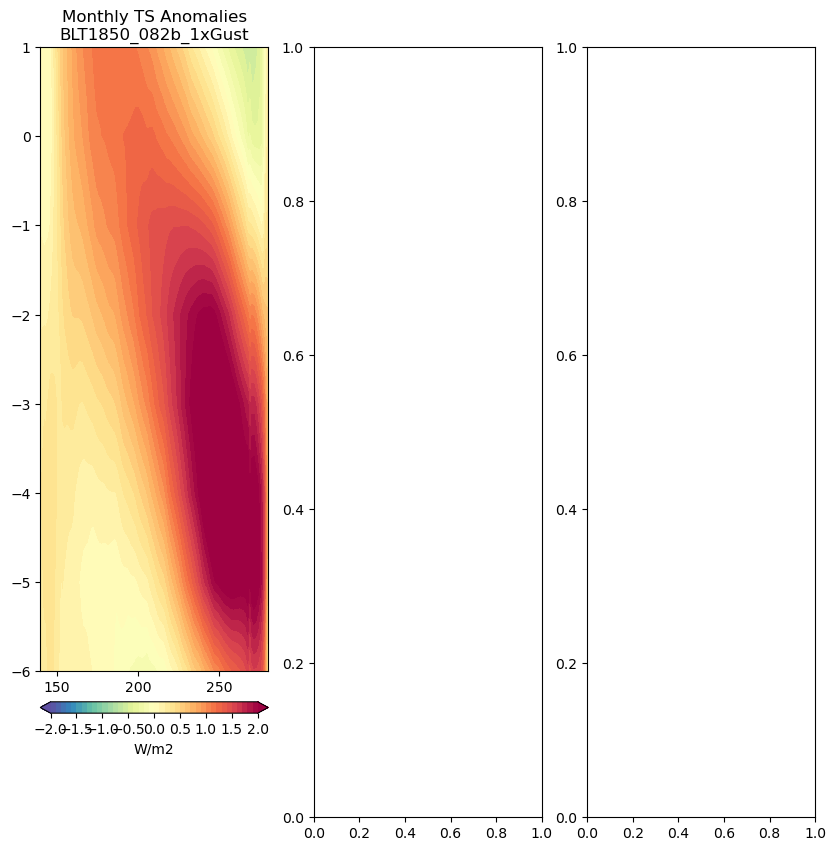

In [52]:
fig,axs  = plt.subplots(1,3, figsize=(10, 10))
axs = axs.ravel()

c = axs[0].contourf(lons, np.arange(-6,2), avg_data, 
                        np.arange(-2, 2.1, 0.1), cmap='Spectral_r', extend='both')
# axs[0].invert_yaxis()  # Reverse the time order to do oldest first
axs[0].set_title('Monthly TS Anomalies\n'+str(anomVar.isel(case=0).case.values))

cbar = plt.colorbar(c, orientation='horizontal', pad=0.04, aspect=20)
cbar.set_label('W/m2')


## Hovmoller diagrams?

In [96]:
ilats = np.where((all_h0.lat.values>=-5)  & (all_h0.lat.values<=5))[0]
ilons = np.where((all_h0.lon.values>=140) & (all_h0.lon.values<=280))[0]

varSel = 'U10'

regionTS = all_h0[varSel].isel(lat=ilats, lon=ilons) * all_h0.OCNFRAC.isel(lat=ilats, lon=ilons)
climoTS  = regionTS.mean(dim='time')

anomVar = (regionTS - climoTS).rolling(time=5).mean()

In [97]:
# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(anomVar.lat.values))
avg_data = (anomVar * weights[None, :, None]).sum(dim='lat') / np.sum(weights)

# Get times and make array of datetime objects
vtimes = anomVar.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = anomVar.lon.values

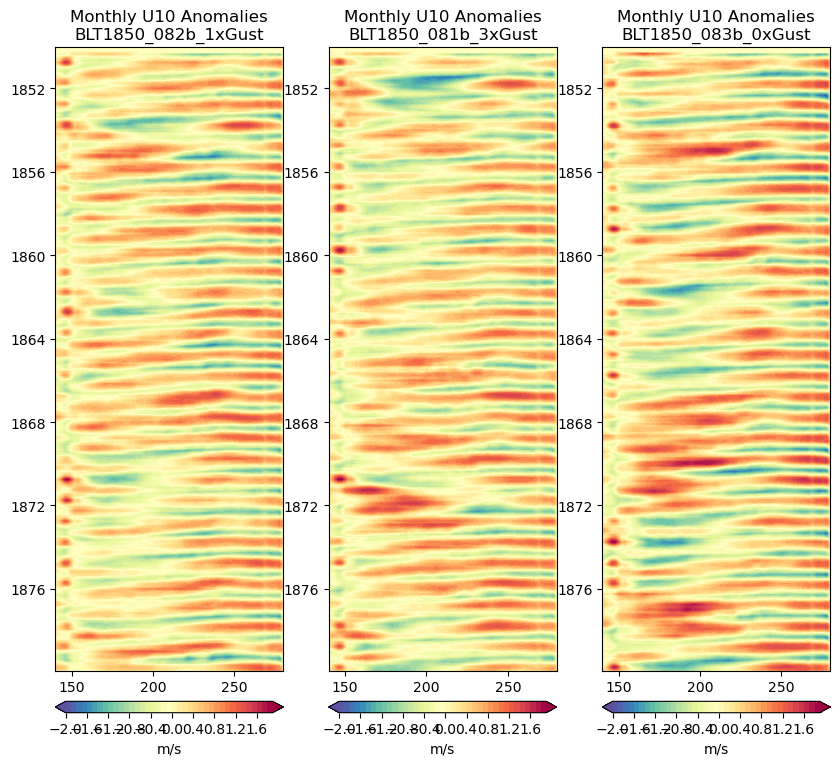

In [98]:
fig,axs  = plt.subplots(1,3, figsize=(10, 10))
axs = axs.ravel()

for iCase in range(len(avg_data.case.values)):
    c = axs[iCase].contourf(lons, vtimes, avg_data.isel(case=iCase).values, 
                            np.arange(-2, 2., 0.1), cmap='Spectral_r', extend='both')
                            # np.arange(-30, 31, 1), cmap='Spectral_r', extend='both')
    axs[iCase].invert_yaxis()  # Reverse the time order to do oldest first
    axs[iCase].set_title('Monthly '+varSel+' Anomalies\n'+str(avg_data.isel(case=iCase).case.values))

    cbar = plt.colorbar(c, orientation='horizontal', pad=0.04, aspect=20)
    cbar.set_label('m/s')


## Pick out individual events?

In [119]:
## Identify start indices of each El Nino event 

# Case 0: 
iValid0 = np.where(np.isfinite(all_h0_ElNino.isel(case=0).nino34.values))[0]
iStarts_case0 = [iValid0[0]]
for t in range(1, len(iValid0)-1):
    if iValid0[t] != iValid0[t-1]+1:
        iStarts_case0 = np.append(iStarts_case0, iValid0[t])

# Case 1: 
iValid1 = np.where(np.isfinite(all_h0_ElNino.isel(case=1).nino34.values))[0]
iStarts_case1 = [iValid1[0]]
for t in range(1, len(iValid1)-1):
    if iValid1[t] != iValid1[t-1]+1:
        iStarts_case1 = np.append(iStarts_case1, iValid1[t])

# Case 2: 
iValid2 = np.where(np.isfinite(all_h0_ElNino.isel(case=2).nino34.values))[0]
iStarts_case2 = [iValid2[0]]
for t in range(1, len(iValid2)-1):
    if iValid2[t] != iValid2[t-1]+1:
        iStarts_case2 = np.append(iStarts_case2, iValid2[t])
        

In [121]:
print(iStarts_case0)
print(iStarts_case1)
print(iStarts_case2)


[ 45 152 237 272 297 333]
[ 21  93 104 165 249 333 344]
[ 45  81  92 103 140 189 273]


**Make Hovmoller's near each start time**

In [201]:
ilats = np.where((all_h0.lat.values>=-5)  & (all_h0.lat.values<=5))[0]
ilons = np.where((all_h0.lon.values>=140) & (all_h0.lon.values<=280))[0]

varSel = 'U850'

regionTS = all_h0[varSel].isel(lat=ilats, lon=ilons) * all_h0.OCNFRAC.isel(lat=ilats, lon=ilons)
climoTS  = regionTS.mean(dim='time')

## Three month moving window?
# anomVar = (regionTS - climoTS).rolling(time=3).mean()
# anomVar = (regionTS - climoTS)
anomVar = regionTS

# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(anomVar.lat.values))
avg_data = (anomVar * weights[None, :, None]).sum(dim='lat') / np.sum(weights)

# Get times and make array of datetime objects
vtimes = anomVar.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = anomVar.lon.values


Text(0.15, 0.92, 'Monthly U850')

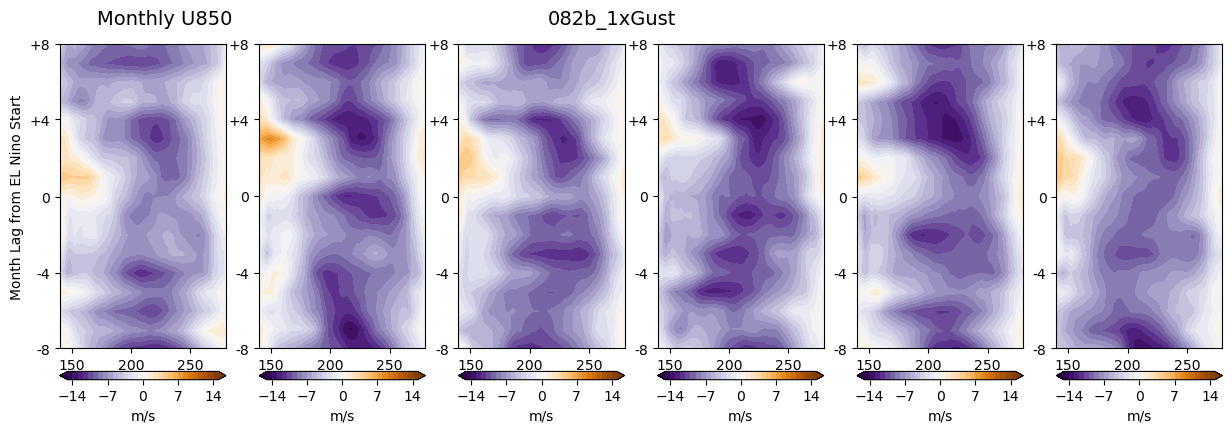

In [206]:
## Case 0 - El Nino's 
fig,axs = plt.subplots(1, len(iStarts_case0), figsize=(15,5))
axs     = axs.ravel()

# clims = np.arange(-4, 4.2, 0.2)
# clims = np.arange(-40, 42, 2)
# clims = np.arange(-2, 2.1, 0.1)
# clims = np.arange(-6, 6.2, 0.2)

clims = np.arange(-15, 16, 1)


for iEvent in range(len(iStarts_case0)):
    c = axs[iEvent].contourf(lons,vtimes,avg_data.isel(case=0).values, 
                    clims, cmap='PuOr_r', extend='both')
    
    # axs[iEvent].invert_yaxis()  # Reverse the time order to do oldest first

    # Isoalte event
    axs[iEvent].set_ylim([vtimes[iStarts_case0[iEvent]-8], vtimes[iStarts_case0[iEvent]+8]])

    # Set labels 
    axs[iEvent].set_yticks([vtimes[iStarts_case0[iEvent]-8], vtimes[iStarts_case0[iEvent]-4], vtimes[iStarts_case0[iEvent]], 
                            vtimes[iStarts_case0[iEvent]+4], vtimes[iStarts_case0[iEvent]+8]])
    axs[iEvent].set_yticklabels(['-8', '-4','0','+4','+8'])

    if iEvent==0:
        axs[iEvent].set_ylabel('Month Lag from EL Nino Start')

    cbar = plt.colorbar(c, orientation='horizontal', pad=0.06, aspect=20)
    cbar.set_label('m/s')
    cbar.ax.locator_params(nbins=5)
        
# Label the plot 
plt.gcf().text(0.45, 0.92, str(avg_data.isel(case=0).case.values)[8::], fontsize=14)
# plt.gcf().text(0.15, 0.92, 'Monthly '+varSel+' Anomalies', fontsize=14)
plt.gcf().text(0.15, 0.92, 'Monthly '+varSel, fontsize=14)


Text(0.15, 0.92, 'Monthly U850')

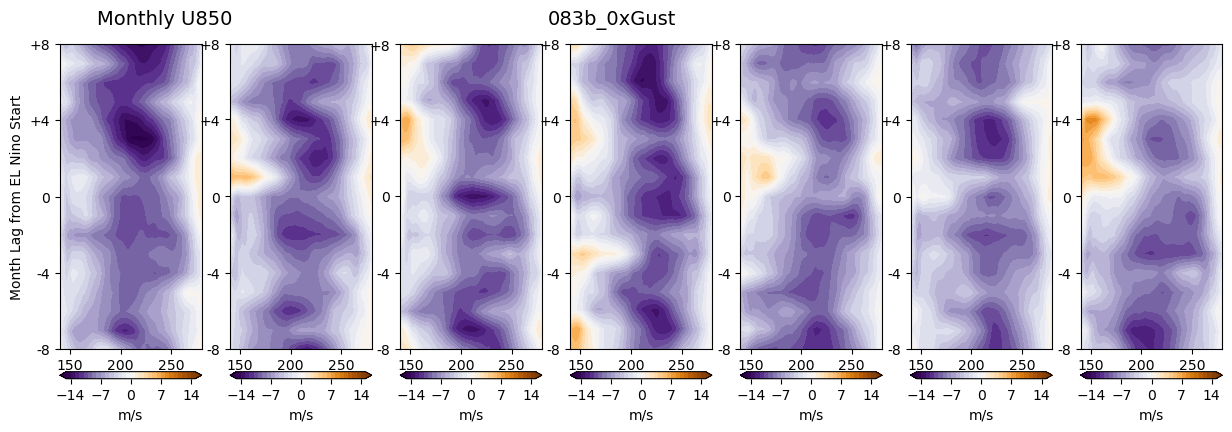

In [205]:
## Case 2 - El Nino's 
fig,axs = plt.subplots(1, len(iStarts_case2), figsize=(15,5))
axs     = axs.ravel()

# clims = np.arange(-4, 4.2, 0.2)
# clims = np.arange(-40, 42, 2)
# clims = np.arange(-2, 2.1, 0.1)

clims = np.arange(-15, 16, 1)

for iEvent in range(len(iStarts_case2)):
    c = axs[iEvent].contourf(lons,vtimes,avg_data.isel(case=2).values, 
                    clims, cmap='PuOr_r', extend='both')
    
    # Isoalte event
    axs[iEvent].set_ylim([vtimes[iStarts_case2[iEvent]-8], vtimes[iStarts_case2[iEvent]+8]])

    # Set labels
    axs[iEvent].set_yticks([vtimes[iStarts_case2[iEvent]-8], vtimes[iStarts_case2[iEvent]-4], vtimes[iStarts_case2[iEvent]], 
                            vtimes[iStarts_case2[iEvent]+4], vtimes[iStarts_case2[iEvent]+8]])
    axs[iEvent].set_yticklabels(['-8', '-4','0','+4','+8'])
    # axs[iEvent].invert_yaxis()  # Reverse the time order to do oldest first

    if iEvent==0:
        axs[iEvent].set_ylabel('Month Lag from EL Nino Start')

    cbar = plt.colorbar(c, orientation='horizontal', pad=0.06, aspect=20)
    cbar.set_label('m/s') 
    cbar.ax.locator_params(nbins=5)

# Label the plot 
plt.gcf().text(0.45, 0.92, str(avg_data.isel(case=2).case.values)[8::], fontsize=14)
# plt.gcf().text(0.15, 0.92, 'Monthly '+varSel+' Anomalies', fontsize=14)
plt.gcf().text(0.15, 0.92, 'Monthly '+varSel, fontsize=14)


## Maps of regressions or correlations?

In [53]:
## Timeseries correlations 

var1 = 'nino34'
var2 = 'U850'

climoVar = weighted_temporal_mean(all_h0, var2).mean(dim='time')
anomVar = all_h0[var2] - climoVar

corrCoef = xr.corr(all_h0[var1], anomVar, dim='time')


In [54]:
longrid, latgrid = np.meshgrid(all_h0['lon'], all_h0['lat'].sel(lat=slice(-60,60)) )


[None, None]

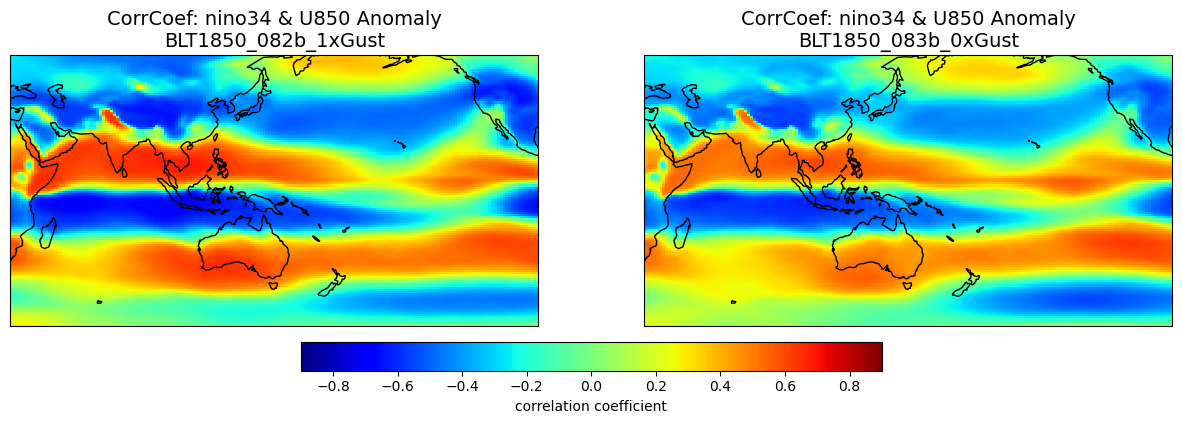

In [55]:
fig,axs = plt.subplots(1,2,figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

corrRegion = corrCoef.sel(lat=slice(-60,60))

var_norm = matplotlib.colors.Normalize(vmin=-0.9, vmax=0.9)

axs[0].pcolormesh(longrid, latgrid, corrRegion.isel(case=0).values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='jet') 
axs[1].pcolormesh(longrid, latgrid, corrRegion.isel(case=2).values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='jet') 

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs, shrink=0.5, 
                      label='correlation coefficient', orientation='horizontal', pad=0.025) 

axs[0].set_title('CorrCoef: '+var1+' & '+var2+' Anomaly\n'+str(corrRegion.isel(case=0).case.values), fontsize=14)
axs[1].set_title('CorrCoef: '+var1+' & '+var2+' Anomaly\n'+str(corrRegion.isel(case=2).case.values), fontsize=14)
[a.coastlines() for a in axs]
[a.set_extent([30,264,-60,60], crs=ccrs.PlateCarree()) for a in axs]


## Dive into daily data a bit more? 

In [ ]:
all_h1

In [196]:
longrid, latgrid = np.meshgrid(all_h1['lon'], all_h1['lat']) 


In [197]:
## Get seasonal standard deviation of U850
var_raw_u850 = all_h1.U850.var(dim='time')
all_h1_seasonVar = all_h1.U850.groupby("time.season").var(dim="time")

[None, None, None]

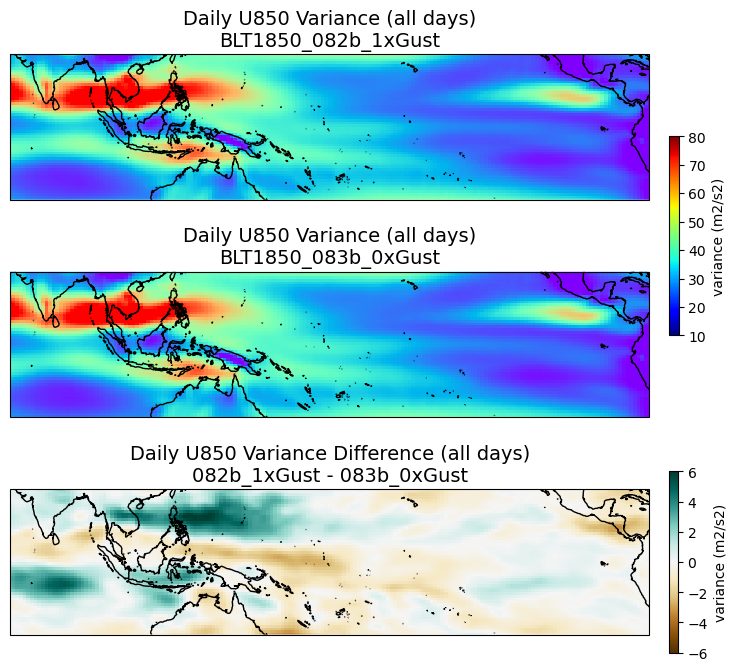

In [198]:
fig,axs = plt.subplots(3,1,figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

var_norm = matplotlib.colors.Normalize(vmin=10, vmax=80)
diff_norm = matplotlib.colors.Normalize(vmin=-6, vmax=6)

## Plot raw variance 
axs[0].pcolormesh(longrid,latgrid,var_raw_u850.isel(case=0).values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')
axs[1].pcolormesh(longrid,latgrid,var_raw_u850.isel(case=1).values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs[0:2], shrink=0.5, 
                      label='variance (m2/s2)', orientation='vertical', pad=0.025) 

axs[0].set_title('Daily U850 Variance (all days)\n'+str(var_raw_u850.isel(case=0).case.values), fontsize=14)
axs[1].set_title('Daily U850 Variance (all days)\n'+str(var_raw_u850.isel(case=1).case.values), fontsize=14)


## Plot difference as well 
axs[2].pcolormesh(longrid, latgrid, (var_raw_u850.isel(case=0) - var_raw_u850.isel(case=1)).values, 
                  transform=ccrs.PlateCarree(), norm=diff_norm, cmap='BrBG')

cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap='BrBG'), ax=axs[2], 
                      label='variance (m2/s2)', orientation='vertical', pad=0.025)
axs[2].set_title('Daily U850 Variance Difference (all days)\n'+str(var_raw_u850.isel(case=0).case.values)[8::]+' - '+str(var_raw_u850.isel(case=1).case.values)[8::], fontsize=14)


[a.coastlines() for a in axs]
# [a.set_extent([60,268,-25,25], crs=ccrs.PlateCarree()) for a in axs]
[a.set_extent([65,285,-25,25], crs=ccrs.PlateCarree()) for a in axs]


[None, None, None]

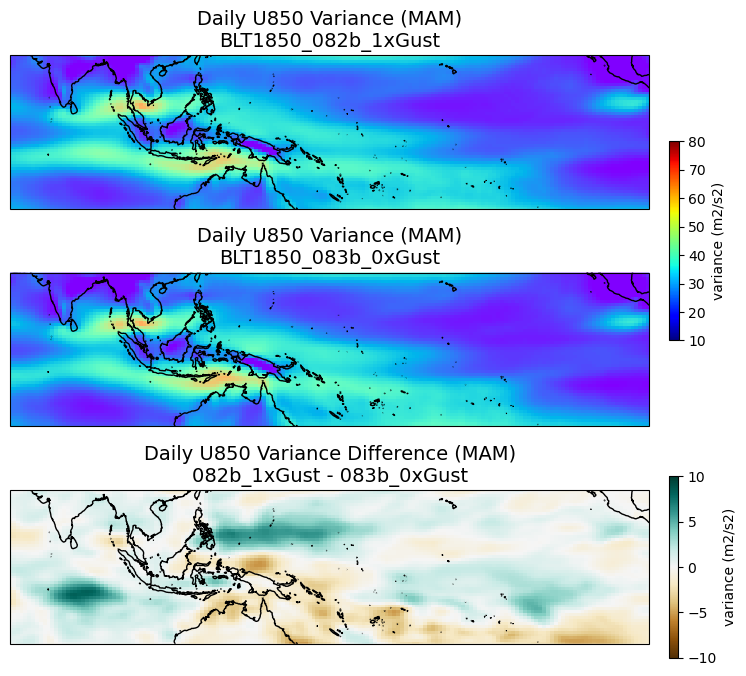

In [37]:
fig,axs = plt.subplots(3,1,figsize=(10,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

var_norm = matplotlib.colors.Normalize(vmin=10, vmax=80)
diff_norm = matplotlib.colors.Normalize(vmin=-10, vmax=10)

seasonSel='MAM'

## Plot raw variance 
axs[0].pcolormesh(longrid,latgrid,all_h1_seasonVar.sel(season=seasonSel).isel(case=0).values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')
axs[1].pcolormesh(longrid,latgrid,all_h1_seasonVar.sel(season=seasonSel).isel(case=1).values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs[0:2], shrink=0.5, 
                      label='variance (m2/s2)', orientation='vertical', pad=0.025) 

axs[0].set_title('Daily U850 Variance ('+seasonSel+')\n'+str(all_h1_seasonVar.isel(case=0).case.values), fontsize=14)
axs[1].set_title('Daily U850 Variance ('+seasonSel+')\n'+str(all_h1_seasonVar.isel(case=1).case.values), fontsize=14)


## Plot difference as well 
axs[2].pcolormesh(longrid, latgrid, (all_h1_seasonVar.sel(season=seasonSel).isel(case=0) - all_h1_seasonVar.sel(season=seasonSel).isel(case=1)).values, 
                  transform=ccrs.PlateCarree(), norm=diff_norm, cmap='BrBG')

cb2 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap='BrBG'), ax=axs[2], 
                      label='variance (m2/s2)', orientation='vertical', pad=0.025)
axs[2].set_title('Daily U850 Variance Difference ('+seasonSel+')\n'+str(all_h1_seasonVar.isel(case=0).case.values)[8::]+' - '+str(all_h1_seasonVar.isel(case=1).case.values)[8::], fontsize=14)


[a.coastlines() for a in axs]
[a.set_extent([60,268,-25,25], crs=ccrs.PlateCarree()) for a in axs]


[None, None]

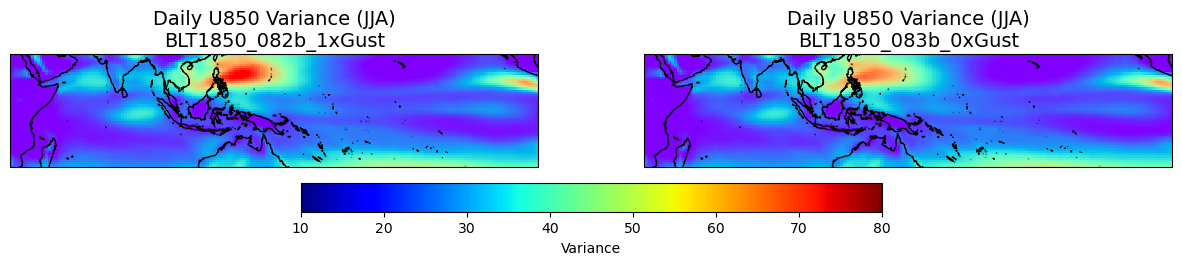

In [47]:
fig,axs = plt.subplots(1,2,figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

var_norm = matplotlib.colors.Normalize(vmin=10, vmax=80)

axs[0].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=0).sel(season='JJA').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')
axs[1].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=1).sel(season='JJA').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs, shrink=0.5, 
                      label='Variance', orientation='horizontal', pad=0.025) 

axs[0].set_title('Daily U850 Variance (JJA)\n'+str(all_h1_seasonVar.isel(case=0).case.values), fontsize=14)
axs[1].set_title('Daily U850 Variance (JJA)\n'+str(all_h1_seasonVar.isel(case=1).case.values), fontsize=14)

[a.coastlines() for a in axs]
[a.set_extent([30,264,-25,25], crs=ccrs.PlateCarree()) for a in axs]


[None, None]

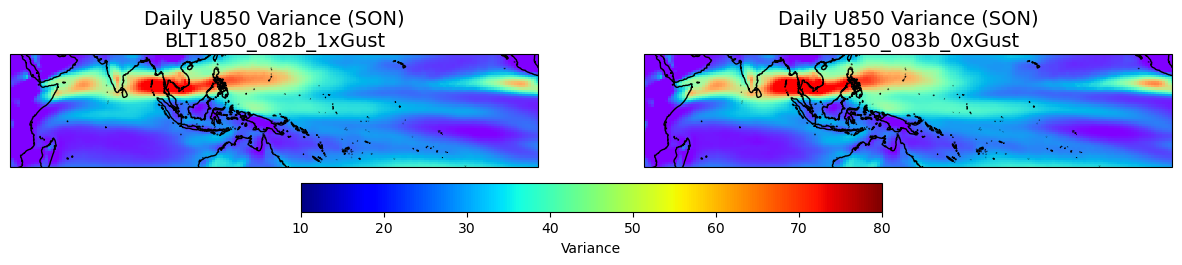

In [48]:
fig,axs = plt.subplots(1,2,figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

var_norm = matplotlib.colors.Normalize(vmin=10, vmax=80)

axs[0].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=0).sel(season='SON').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')
axs[1].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=1).sel(season='SON').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs, shrink=0.5, 
                      label='Variance', orientation='horizontal', pad=0.025) 

axs[0].set_title('Daily U850 Variance (SON)\n'+str(all_h1_seasonVar.isel(case=0).case.values), fontsize=14)
axs[1].set_title('Daily U850 Variance (SON)\n'+str(all_h1_seasonVar.isel(case=1).case.values), fontsize=14)

[a.coastlines() for a in axs]
[a.set_extent([30,264,-25,25], crs=ccrs.PlateCarree()) for a in axs]


[None, None]

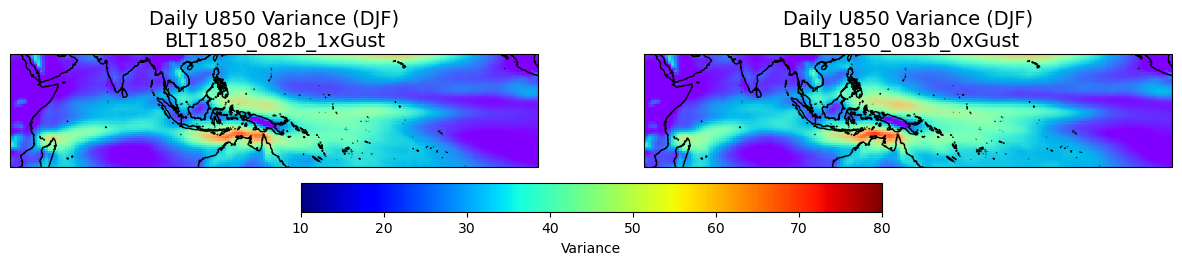

In [49]:
fig,axs = plt.subplots(1,2,figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

var_norm = matplotlib.colors.Normalize(vmin=10, vmax=80)

axs[0].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=0).sel(season='DJF').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')
axs[1].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=1).sel(season='DJF').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs, shrink=0.5, 
                      label='Variance', orientation='horizontal', pad=0.025) 

axs[0].set_title('Daily U850 Variance (DJF)\n'+str(all_h1_seasonVar.isel(case=0).case.values), fontsize=14)
axs[1].set_title('Daily U850 Variance (DJF)\n'+str(all_h1_seasonVar.isel(case=1).case.values), fontsize=14)

[a.coastlines() for a in axs]
[a.set_extent([30,264,-25,25], crs=ccrs.PlateCarree()) for a in axs]


[None, None]

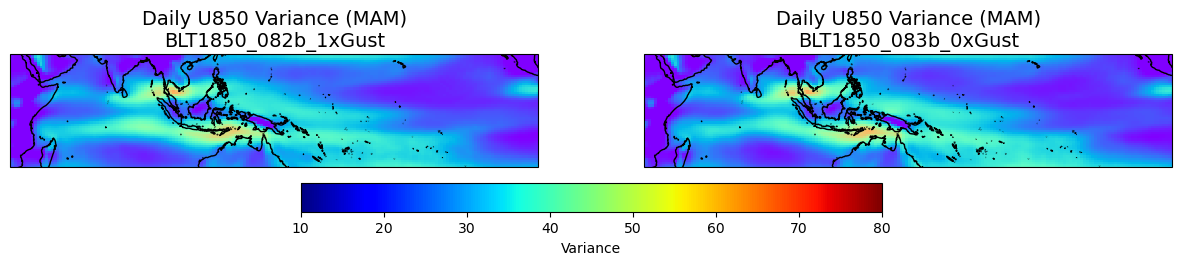

In [50]:
fig,axs = plt.subplots(1,2,figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel()

var_norm = matplotlib.colors.Normalize(vmin=10, vmax=80)

axs[0].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=0).sel(season='MAM').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')
axs[1].pcolormesh(longrid,latgrid,all_h1_seasonVar.isel(case=1).sel(season='MAM').values, 
                  transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow')

cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap='jet'), ax=axs, shrink=0.5, 
                      label='Variance', orientation='horizontal', pad=0.025) 

axs[0].set_title('Daily U850 Variance (MAM)\n'+str(all_h1_seasonVar.isel(case=0).case.values), fontsize=14)
axs[1].set_title('Daily U850 Variance (MAM)\n'+str(all_h1_seasonVar.isel(case=1).case.values), fontsize=14)

[a.coastlines() for a in axs]
[a.set_extent([30,264,-25,25], crs=ccrs.PlateCarree()) for a in axs]


In [31]:
# ## Band-pass filter U850 using Will's utilities script 
# ## (and climo files from there) 

dir_in = '/glade/derecho/scratch/mdfowler/ADF/b.e23_alpha16g.BLT1850.ne30_t232.082b/ts/climo/'

filolr =  'b.e23_alpha16g.BLT1850.ne30_t232.082b.cam.h2.FLUT.anomalies.0009010100000-0061122700000.nc'
var_name_olr = 'FLUT'

file_path_olr = os.path.join(dir_in, filolr)  # Join the directory and file name
DS_olr = xr.open_dataset(file_path_olr)

# Define bandpass frequency limits
f_low  = 100  # Corresponds to  days period
f_high = 20   # Corresponds to 20 days period

bandPass_data = np.full([len(), len(), len()], np.nan)

testBandpass_case0 = utilities.bandpass_filter_via_fft_2d(np.array(DS_olr['U850']), f_high, f_low, sampling_interval=1)
# testBandpass_case1 = utilities.bandpass_filter_via_fft_2d(np.array(all_h1['U850'].isel(case=1)), f_high, f_low, sampling_interval=1)


In [34]:
# import scipy.signal
# import scipy.io.wavfile
# import matplotlib.pyplot as plt

# def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
#     sos = scipy.signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
#     filtered_data = scipy.signal.sosfiltfilt(sos, data)
#     return filtered_data

# # # Load sample data from a WAV file
# # sample_rate, data = scipy.io.wavfile.read('ecg.wav')
# # times = np.arange(len(data))/sample_rate

# # Apply a 10-50 Hz high-pass filter to the original data
# filtered = bandpass(np.array(DS_olr[var_name_olr]), [f_high, f_low], 1)


In [ ]:
np.shape(filtered)

## Anomaly Correlations 

In [147]:
varLag = 'TS' 
lag = 0 

x_timeseries = all_h0.isel(case=0).nino34
y_timeseries = all_h0[varLag].isel(case=0)




In [ ]:
# [case, time, lat, lon]
monLag = 6
corr_timeseries = np.full([len(all_h0.case.values),  len(all_h0.time.values), 
                           len(all_h0.lat.values),   len(all_h0.lon.values)], np.nan)

for iT in range(len(all_h0.time.values)-monLag): 
    nino34_thisTime = all_h0.nino34.isel(time=iT+monLag)
    sst_thisTime    = all_h0.TS.isel(time=iT)


In [54]:
# case, time, lat, lon
# lag = -6
# corr_timeseries = np.full([len(all_h0.case.values),  len(all_h0.time.values), 
#                            len(all_h0.lat.values),   len(all_h0.lon.values)], np.nan)

for iYr in range(len(nino34_ndj.time.values)):

    
    # # El Nino 
    # if nino34_ndj.isel(time=iYr, case=0) >= 1: 
    #     lagTime = nino34_ndj.isel(time=iYr, case=0).time.values - np.timedelta64(6,'M')
    #     print(lagTime) 

    


UFuncTypeError: Cannot cast ufunc 'subtract' input 1 from dtype('<m8[M]') to dtype('<m8[ns]') with casting rule 'same_kind'

In [57]:
nino34_ndj.isel(time=iYr, case=0).time.values - np.timedelta64(6,'M')

UFuncTypeError: Cannot cast ufunc 'subtract' input 1 from dtype('<m8[M]') to dtype('<m8[ns]') with casting rule 'same_kind'

In [56]:
np.timedelta64(6,'M')

numpy.timedelta64(6,'M')

In [44]:
iT = 12
nino34_time = all_h0.nino34.isel(time=iT+6)
sst_time    = all_h0.TS.isel(time=iT) 



## Enso lag corr (based on Rich's NCL script) 

In [13]:
## Some basics - the region to focus on, for one
lat_n = 30.0
lat_s = -30.0


## Nino options
## - - - - - - -
# nregions = (/0.,5.,5.,5.,5.,16./)
# sregions = (/-10.,-5.,-5.,-5.,-5.,8./)
# wregions = (/270.,210.,190.,160.,120.,140./)
# eregions = (/280.,270.,240.,210.,140.,160./)

# names_regions = (/"nino1+2","nino3","nino3.4","nino4","nino5","nino6"/)

# Nino3.4
lat_n34 = 5
lat_s34 = -5
lon_e34 = 190 
lon_w34 = 240



In [15]:
## Get observed SSTs
##   Note 7/30/24: Something about the obs piece seems wonky; getting negative corrs that
##   don't show up in Rich's plots
##   Fixed 8/19/2024 - needed to detrend over axis 0, not 1 (no case dimension for obs)

obsName = 'HadISST'
obs_file = "/glade/work/rneale/data/HADLEY/sst.hadley.187001-200512.nc"

obsDS    = xr.open_dataset(obs_file)

# Make times a more useful format
obsTimes = [ datetime.datetime.strptime(np.asarray(obsDS.time.values).astype('str')[x], '%Y%M') for x in range(len(obsDS.time.values)) ]
obsDS['time'] = obsTimes

# Select lower latitudes 
ilatsObs = np.where((obsDS.lat.values>=lat_s) & (obsDS.lat.values<=lat_n))[0]
obsDS = obsDS.isel(lat=ilatsObs)

# Select years 1955-2005 
iselYears = np.where((obsDS['time.year'].values>=1955) & (obsDS['time.year'].values<=2005))[0]
obsDS = obsDS.isel(time=iselYears)

# Convert longitudes to be 0-360  
lon2   = np.mod((obsDS.lon.values), 360.0)
flipPoint = int(np.where( (lon2>=0) & (lon2<1) )[0])
obsDS['lon'] = lon2
obsDS        = obsDS.roll(lon=flipPoint, roll_coords=True) #Handle needing to shift longitudes to start at 0


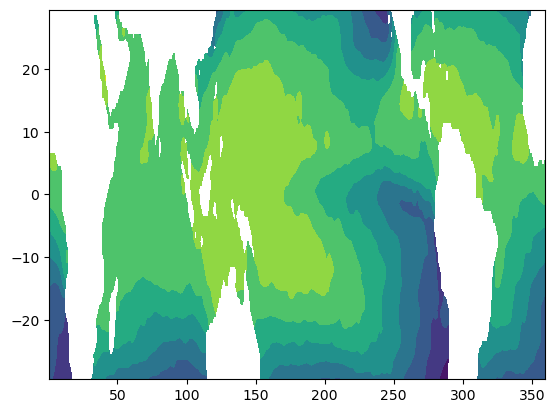

In [16]:
plt.contourf(obsDS.lon.values, obsDS.lat.values, obsDS.SST.isel(time=10).values)


In [17]:
# Updating limit of ocnfrac used to determine mask
ocnMask = all_h0.OCNFRAC.values
ocnMask[ocnMask<=0.65] = np.nan

In [18]:
# Select large latitude region in all_h0 
sst   = all_h0.TS.sel(lat=slice(lat_s,lat_n))
u10   = all_h0.U10.sel(lat=slice(lat_s,lat_n))
lhflx = all_h0.LHFLX.sel(lat=slice(lat_s,lat_n))
u850  = all_h0.U850.sel(lat=slice(lat_s,lat_n))

## Detrend data 
sst   = signal.detrend(sst,   axis=1, type='linear')
u10   = signal.detrend(u10,   axis=1, type='linear')
lhflx = signal.detrend(lhflx, axis=1, type='linear')
u850  = signal.detrend(u850, axis=1, type='linear')

# Mask out ocean 
iLats = np.where((all_h0.lat.values>=-30) & (all_h0.lat.values <= 30) )[0]
sst   = sst   * ocnMask[:,:,iLats,:]
u10   = u10   * ocnMask[:,:,iLats,:]
lhflx = lhflx * ocnMask[:,:,iLats,:]
u850  = u850  * ocnMask[:,:,iLats,:]


In [19]:
## Detrend for observations too
##   This is a little wonky because signal.detrend can't handle NaNs so replacing with a marker that we mask later
sst_obs = np.copy(obsDS.SST.values)

sst_obsFill = sst_obs
sst_obsFill[(np.isnan(sst_obsFill))] = -99

sst_obsFill_detrend = signal.detrend(sst_obsFill, axis=0, type='linear')

sst_obs_detrend = np.copy(obsDS.SST.values)
sst_obs_detrend[np.isfinite(sst_obs_detrend)] = sst_obsFill_detrend[np.isfinite(sst_obs_detrend)]



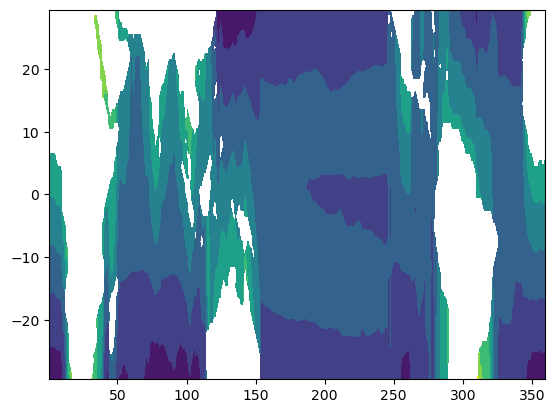

In [373]:
plt.contourf(sst_obs.lon.values, sst_obs.lat.values, sst_obs.isel(time=10))

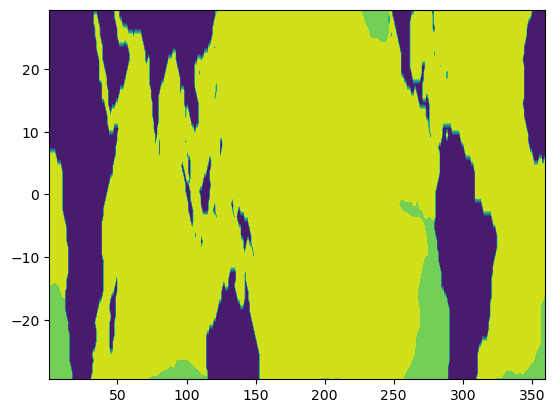

In [377]:
plt.contourf(sst_obs.lon.values, sst_obs.lat.values, sst_obsFill[10,:,:])

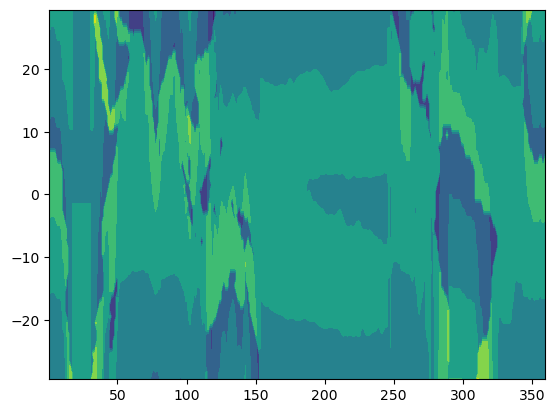

In [378]:
plt.contourf(sst_obs.lon.values, sst_obs.lat.values, sst_obsFill_detrend[10,:,:])

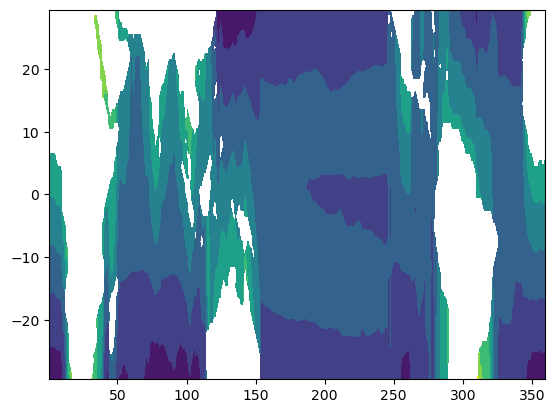

In [379]:
plt.contourf(sst_obs.lon.values, sst_obs.lat.values, sst_obs_detrend[10,:,:])

In [20]:
sst = xr.DataArray(sst, 
    coords={'case': all_h0.case.values,
            'time': all_h0.time.values,
            'lat': all_h0.sel(lat=slice(lat_s,lat_n)).lat.values, 
            'lon':all_h0.lon.values}, 
    dims=["case", "time", "lat", "lon"])

u10 = xr.DataArray(u10, 
    coords={'case': all_h0.case.values,
            'time': all_h0.time.values,
            'lat': all_h0.sel(lat=slice(lat_s,lat_n)).lat.values, 
            'lon':all_h0.lon.values}, 
    dims=["case", "time", "lat", "lon"])

lhflx = xr.DataArray(lhflx, 
    coords={'case': all_h0.case.values,
            'time': all_h0.time.values,
            'lat': all_h0.sel(lat=slice(lat_s,lat_n)).lat.values, 
            'lon':all_h0.lon.values}, 
    dims=["case", "time", "lat", "lon"])

u850 = xr.DataArray(u850, 
    coords={'case': all_h0.case.values,
            'time': all_h0.time.values,
            'lat': all_h0.sel(lat=slice(lat_s,lat_n)).lat.values, 
            'lon':all_h0.lon.values}, 
    dims=["case", "time", "lat", "lon"])


In [21]:
sst_obs = xr.DataArray(sst_obs_detrend, 
    coords={
            'time': obsDS.time.values,
            'lat': obsDS.lat.values, 
            'lon':obsDS.lon.values}, 
    dims=["time", "lat", "lon"])


In [22]:
## Calculate nino anomalies 
def rmMonAnnCyc(DS): 
    
    climatology = DS.groupby("time.month").mean("time")
    anomalies   = DS.groupby("time.month") - climatology    

    return anomalies

# Remove annual cycle from monthly data 
sst_anom = rmMonAnnCyc(sst)
u10_anom = rmMonAnnCyc(u10)
lhflx_anom = rmMonAnnCyc(lhflx)
u850_anom = rmMonAnnCyc(u850)

sstObs_anom = rmMonAnnCyc(sst_obs)


In [23]:
## Compute nino 3.4 index

ilats = np.where((sst_anom.lat.values>=lat_s34)  & (sst_anom.lat.values<=lat_n34))[0]
ilons = np.where((sst_anom.lon.values>=lon_e34)  & (sst_anom.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTS = sst_anom.isel(lat=ilats, lon=ilons)
coswgt   = np.cos(np.deg2rad(regionTS.lat))

nino34 = regionTS.weighted(coswgt).mean(('lon','lat'))

## - - - - - - - - - - - -
## Do the same for obs
ilatsObs = np.where((sstObs_anom.lat.values>=lat_s34)  & (sstObs_anom.lat.values<=lat_n34))[0]
ilonsObs = np.where((sstObs_anom.lon.values>=lon_e34)  & (sstObs_anom.lon.values<=lon_w34))[0]

# Compute weights and get Nino3.4 
regionTSobs = sstObs_anom.isel(lat=ilatsObs, lon=ilonsObs)
coswgt_obs  = np.cos(np.deg2rad(regionTSobs.lat))

nino34_obs = regionTSobs.weighted(coswgt_obs).mean(('lon','lat'))



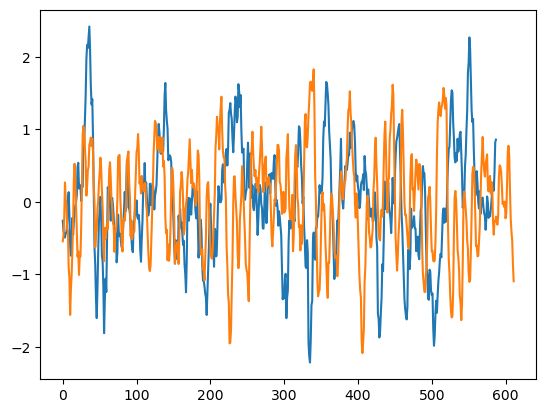

In [353]:
plt.plot(nino34.isel(case=0))
plt.plot(nino34_obs.values)

In [27]:
# # Possibly useful for plotting; may be able to delete 
# longrid, latgrid = np.meshgrid(sst_anom['lon'], sst_anom['lat'])


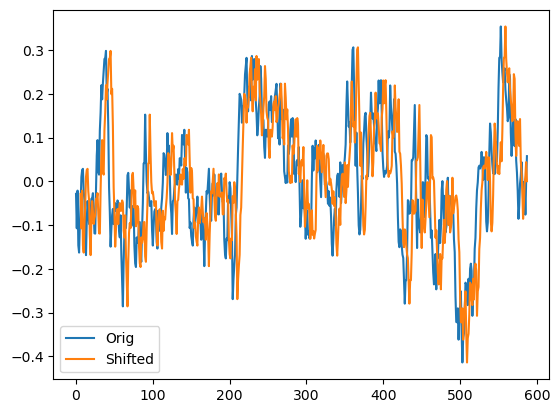

In [41]:
plt.plot(B.mean(dim='lat').mean(dim='lon')) 
plt.plot(B.shift(time=6).mean(dim='lat').mean(dim='lon') )
plt.legend(['Orig','Shifted'])


In [24]:
def getLagCorr(lag, corDS, iCase):

    if lag>0: 
        A  = nino34.isel(case=iCase)[:-lag]
        # B  = sst_anom.isel(case=iCase).shift(time=lag).isel(time=slice(lag,len(sst_anom.time.values)))
        # B['time'] = sst_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
        B  = corDS.isel(case=iCase).shift(time=-lag).isel(time=slice(0,len(corDS.time.values)-lag))
        B['time'] = corDS.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34.isel(case=iCase)[-lag:]
        A['time'] = nino34.time.values[:lag]
        B  = corDS.isel(case=iCase).isel(time=slice(0,len(corDS.time.values)+lag))
    elif lag==0:
        A = nino34.isel(case=iCase)
        B = corDS.isel(case=iCase)
            
    cor = xr.corr(A, B, dim="time")

    return cor

def getLagCorr_obs(lag):

    if lag>0: 
        A  = nino34_obs[:-lag]
        B  = sstObs_anom.shift(time=-lag).isel(time=slice(0,len(sstObs_anom.time.values)-lag))
        B['time'] = sstObs_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs
    elif lag<0:
        A  = nino34_obs[-lag:]
        A['time'] = nino34_obs.time.values[:lag]
        B  = sstObs_anom.isel(time=slice(0,len(sstObs_anom.time.values)+lag))
    elif lag==0:
        A = nino34_obs
        B = sstObs_anom
            
    cor = xr.corr(A, B, dim="time")

    return cor
    

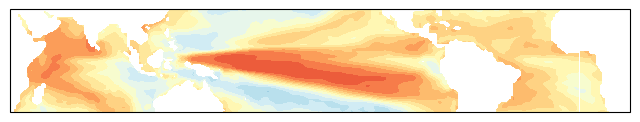

In [392]:
cor = getLagCorr(6, sst_anom, 0)

pltLims = np.arange(-1,1.1,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), 
                       subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})

img1 = ax.contourf(sst_anom.lon.values,sst_anom.lat.values, cor, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 


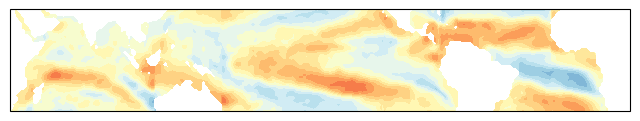

In [357]:
cor = getLagCorr_obs(6)

pltLims = np.arange(-1,1.1,0.1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), 
                       subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})

img1 = ax.contourf(sstObs_anom.lon.values,sstObs_anom.lat.values, cor, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
# fig.colorbar(img1)


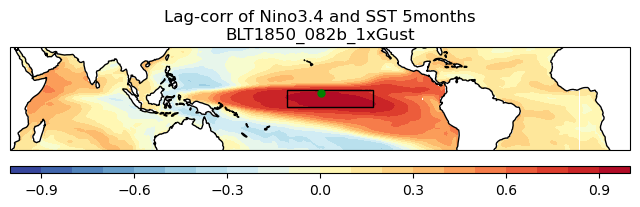

In [178]:
# # Plot lagged correlation 
# lag     = 5
# iCase   = 0 
# caseStr = all_h0.isel(case=iCase).case.values

# A  = nino34.isel(case=iCase)[:-lag]
# B  = sst_anom.isel(case=iCase).shift(time=lag).isel(time=slice(lag,len(sst_anom.time.values)))
# B['time'] = sst_anom.time.values[:-lag]  # To get xr.corr to work, need to have the "same" time for computing corrs

# corM6 = xr.corr(A, B, dim="time")

# ## Make plot 
# pltLims = np.arange(-1,1.1,0.1)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10), 
#                        subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})

# img1 = ax.contourf(sst_anom.lon.values,sst_anom.lat.values,corM6, pltLims,
#                    cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 

# ax.plot(sst_anom.sel(lat=ilat,lon=ilon,method='nearest').lon.values, 
#        sst_anom.sel(lat=ilat,lon=ilon,method='nearest').lat.values, 'go', markersize=5,  transform=ccrs.PlateCarree())

# ax.coastlines()
# ax.set_title('Lag-corr of Nino3.4 and SST '+str(lag)+'months\n'+str(caseStr))

# # Add rectangle for nino3.4 region 
# ax.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
#                             facecolor='none', edgecolor='k',
#                             linewidth=1, transform=ccrs.PlateCarree()))

# cax = ax.inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
# cbar = fig.colorbar(img1, cax = cax, orientation="horizontal")
# # cbar.ax.set_xlabel(unitStr)
# # cbar.ax.locator_params(nbins=6)



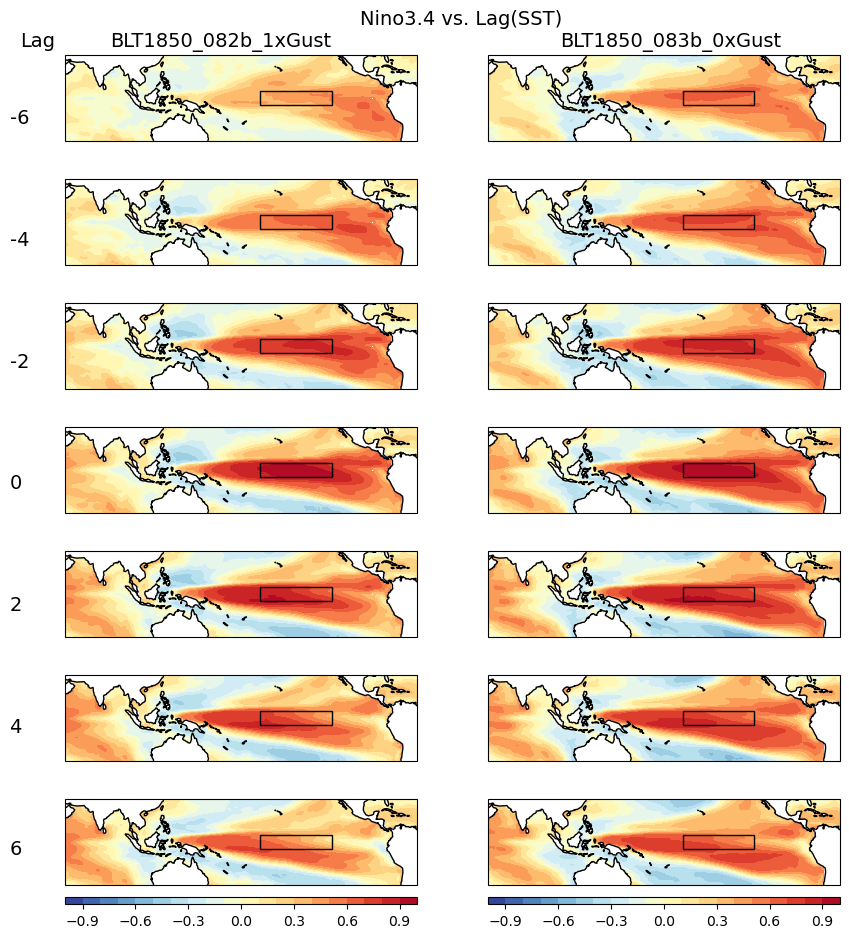

In [29]:
## More complete plot 

maxLag = 6
# lags = np.arange(-maxLag,maxLag+1)
lags = np.arange(-maxLag,maxLag+1,2)

fig,axs = plt.subplots(len(lags),2, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs = axs.ravel()

plt.gcf().text(0.08, 0.88, 'Lag', fontsize=14)
plt.gcf().text(0.42, 0.90, 'Nino3.4 vs. Lag(SST)', fontsize=14)
plt.gcf().text(0.17, 0.88, str(sst_anom.isel(case=0).case.values), fontsize=14)
plt.gcf().text(0.62, 0.88, str(sst_anom.isel(case=1).case.values), fontsize=14)

pltLims = np.arange(-1,1.1,0.1)

for iLag in range(len(lags)):
    cor_case0 = getLagCorr(lags[iLag],sst_anom, 0)
    cor_case1 = getLagCorr(lags[iLag],sst_anom, 1)

    c1 = axs[(iLag*2)].contourf(sst_anom.lon.values,sst_anom.lat.values ,  cor_case0, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
    c2 = axs[(iLag*2)+1].contourf(sst_anom.lon.values,sst_anom.lat.values, cor_case1, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 

    if lags[iLag]==maxLag:
        cax = axs[iLag*2].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

        cax = axs[(iLag*2)+1].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

    plt.gcf().text(0.07, 0.81-(iLag/len(lags))*0.775, str(lags[iLag]), fontsize=14)
    
[a.coastlines() for a in axs]
[a.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',
                            linewidth=1, transform=ccrs.PlateCarree())) for a in axs]

[a.set_extent([53,300,-30,30], crs=ccrs.PlateCarree()) for a in axs]

plt.show()



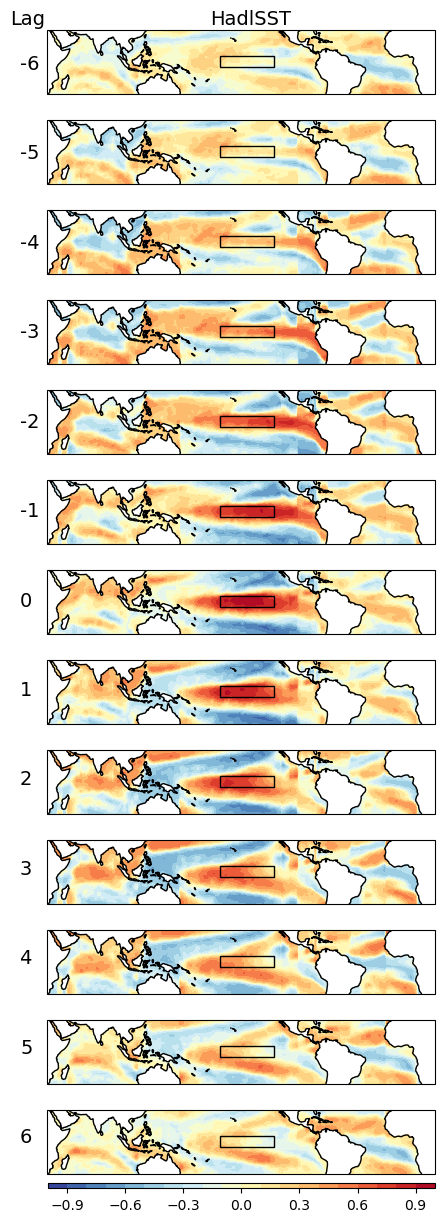

In [369]:
## More complete plot 

maxLag = 6
lags   = np.arange(-maxLag,maxLag+1)

fig,axs = plt.subplots(len(lags),1, figsize=(5,15), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs = axs.ravel()

plt.gcf().text(0.05, 0.88, 'Lag', fontsize=14)
plt.gcf().text(0.45, 0.88, 'HadlSST', fontsize=14)

pltLims = np.arange(-1,1.1,0.1)

for iLag in range(len(lags)):
    cor_obs = getLagCorr_obs(lags[iLag])

    c1 = axs[iLag].contourf(sstObs_anom.lon.values,sstObs_anom.lat.values ,  cor_obs, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 


    if lags[iLag]==maxLag:
        cax = axs[iLag].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

    plt.gcf().text(0.07, 0.85-(iLag/len(lags))*0.775, str(lags[iLag]), fontsize=14)
    
[a.coastlines() for a in axs]
[a.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',
                            linewidth=1, transform=ccrs.PlateCarree())) for a in axs]

plt.show()


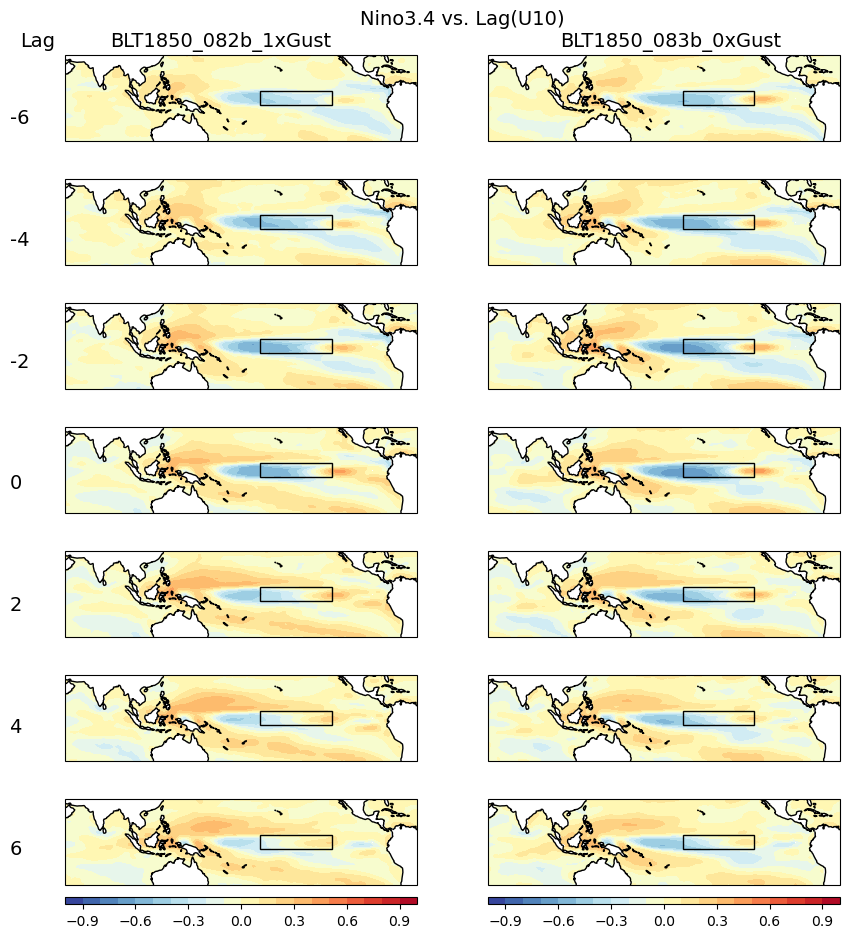

In [30]:
## More complete plot 

maxLag = 6
# lags = np.arange(-maxLag,maxLag+1)
lags = np.arange(-maxLag,maxLag+1,2)

fig,axs = plt.subplots(len(lags),2, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs = axs.ravel()

plt.gcf().text(0.08, 0.88, 'Lag', fontsize=14)
plt.gcf().text(0.42, 0.90, 'Nino3.4 vs. Lag(U10)', fontsize=14)
plt.gcf().text(0.17, 0.88, str(u10_anom.isel(case=0).case.values), fontsize=14)
plt.gcf().text(0.62, 0.88, str(u10_anom.isel(case=1).case.values), fontsize=14)

pltLims = np.arange(-1,1.1,0.1)

for iLag in range(len(lags)):
    cor_case0 = getLagCorr(lags[iLag],u10_anom, 0)
    cor_case1 = getLagCorr(lags[iLag],u10_anom, 1)

    c1 = axs[(iLag*2)].contourf(u10_anom.lon.values,u10_anom.lat.values ,  cor_case0, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
    c2 = axs[(iLag*2)+1].contourf(u10_anom.lon.values,u10_anom.lat.values, cor_case1, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 

    if lags[iLag]==maxLag:
        cax = axs[iLag*2].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

        cax = axs[(iLag*2)+1].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

    plt.gcf().text(0.07, 0.81-(iLag/len(lags))*0.775, str(lags[iLag]), fontsize=14)
    
[a.coastlines() for a in axs]
[a.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',
                            linewidth=1, transform=ccrs.PlateCarree())) for a in axs]

[a.set_extent([53,300,-30,30], crs=ccrs.PlateCarree()) for a in axs]


plt.show()


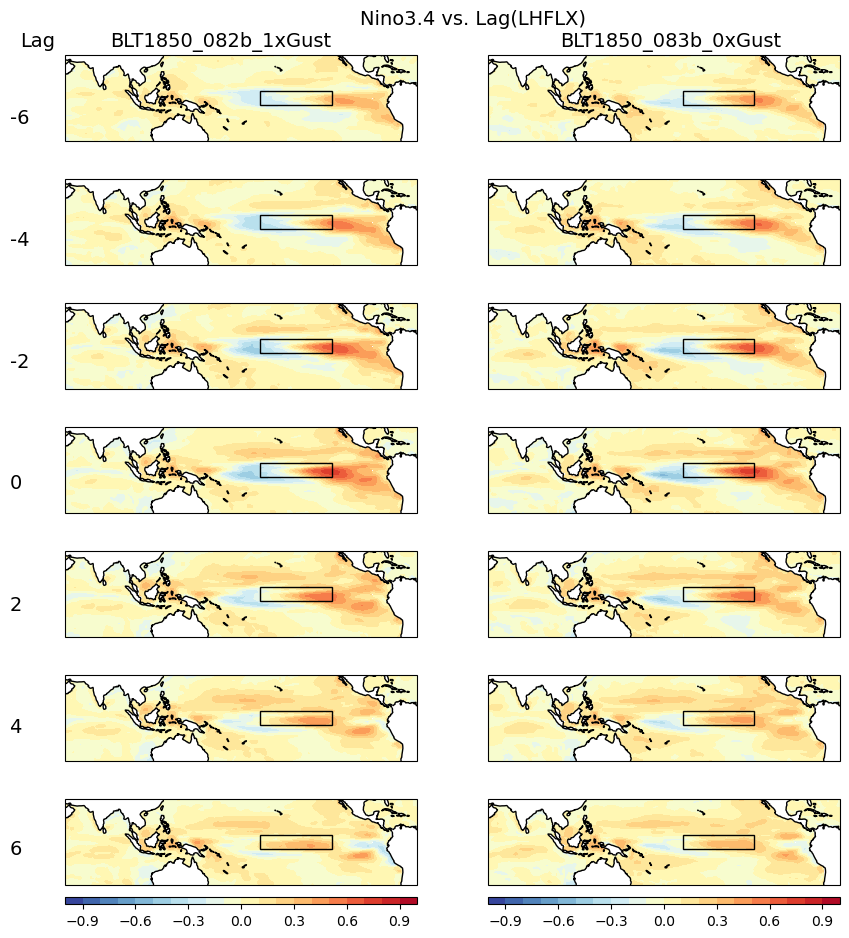

In [31]:
## More complete plot 

maxLag = 6
# lags = np.arange(-maxLag,maxLag+1)
lags = np.arange(-maxLag,maxLag+1,2)

fig,axs = plt.subplots(len(lags),2, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs = axs.ravel()

plt.gcf().text(0.08, 0.88, 'Lag', fontsize=14)
plt.gcf().text(0.42, 0.90, 'Nino3.4 vs. Lag(LHFLX)', fontsize=14)
plt.gcf().text(0.17, 0.88, str(lhflx_anom.isel(case=0).case.values), fontsize=14)
plt.gcf().text(0.62, 0.88, str(lhflx_anom.isel(case=1).case.values), fontsize=14)

pltLims = np.arange(-1,1.1,0.1)

for iLag in range(len(lags)):
    cor_case0 = getLagCorr(lags[iLag],lhflx_anom, 0)
    cor_case1 = getLagCorr(lags[iLag],lhflx_anom, 1)

    c1 = axs[(iLag*2)].contourf(lhflx_anom.lon.values, lhflx_anom.lat.values ,  cor_case0, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
    c2 = axs[(iLag*2)+1].contourf(lhflx_anom.lon.values, lhflx_anom.lat.values, cor_case1, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 

    if lags[iLag]==maxLag:
        cax = axs[iLag*2].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

        cax = axs[(iLag*2)+1].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

    plt.gcf().text(0.07, 0.81-(iLag/len(lags))*0.775, str(lags[iLag]), fontsize=14)
    
[a.coastlines() for a in axs]
[a.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',
                            linewidth=1, transform=ccrs.PlateCarree())) for a in axs]

[a.set_extent([53,300,-30,30], crs=ccrs.PlateCarree()) for a in axs]

plt.show()


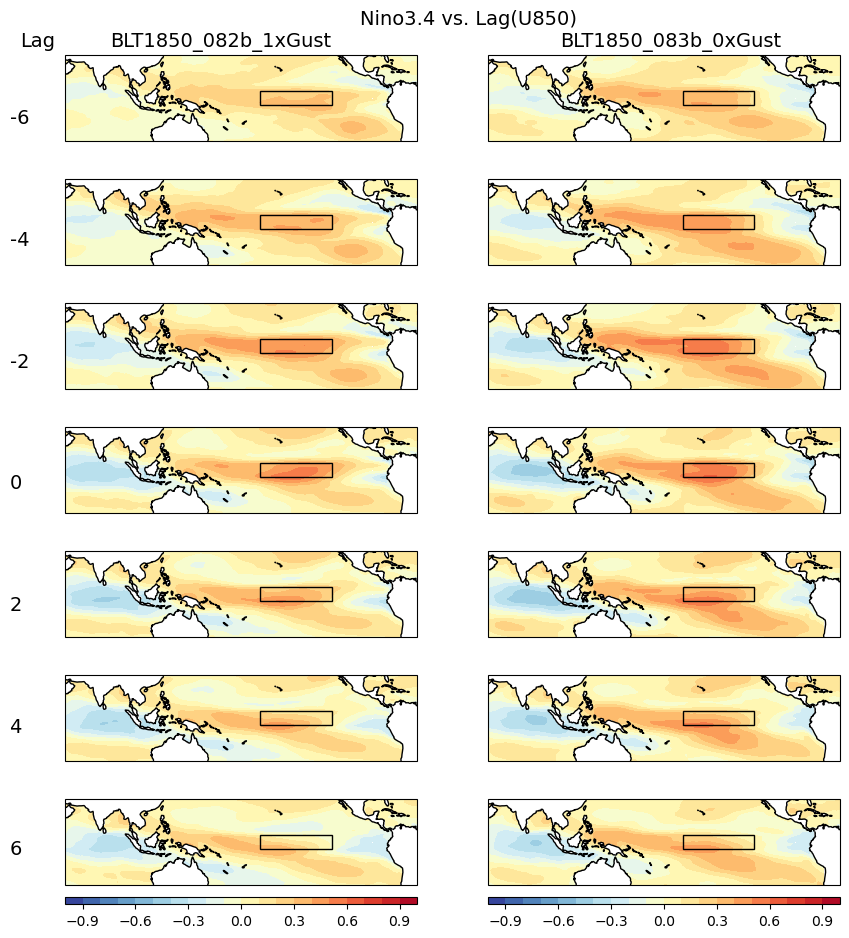

In [32]:
## More complete plot 

maxLag = 6
# lags = np.arange(-maxLag,maxLag+1)
lags = np.arange(-maxLag,maxLag+1,2)

fig,axs = plt.subplots(len(lags),2, figsize=(10,11), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=210)})
axs = axs.ravel()

plt.gcf().text(0.08, 0.88, 'Lag', fontsize=14)
plt.gcf().text(0.42, 0.90, 'Nino3.4 vs. Lag(U850)', fontsize=14)
plt.gcf().text(0.17, 0.88, str(u850_anom.isel(case=0).case.values), fontsize=14)
plt.gcf().text(0.62, 0.88, str(u850_anom.isel(case=1).case.values), fontsize=14)

pltLims = np.arange(-1,1.1,0.1)

for iLag in range(len(lags)):
    cor_case0 = getLagCorr(lags[iLag], u850_anom, 0)
    cor_case1 = getLagCorr(lags[iLag], u850_anom, 1)

    c1 = axs[(iLag*2)].contourf(u850_anom.lon.values, u850_anom.lat.values ,  cor_case0, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 
    c2 = axs[(iLag*2)+1].contourf(u850_anom.lon.values, u850_anom.lat.values, cor_case1, pltLims,
                   cmap='RdYlBu_r', transform=ccrs.PlateCarree() ) 

    if lags[iLag]==maxLag:
        cax = axs[iLag*2].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

        cax = axs[(iLag*2)+1].inset_axes([0, -0.23, 1, 0.09])  # THE NEW AXES, x, y, width, height,
        cbar = fig.colorbar(c1, cax = cax, orientation="horizontal")

    plt.gcf().text(0.07, 0.81-(iLag/len(lags))*0.775, str(lags[iLag]), fontsize=14)
    
[a.coastlines() for a in axs]
[a.add_patch(patches.Rectangle(xy=[lon_e34, lat_s34], width=(lon_w34-lon_e34), height=(lat_n34-lat_s34),
                            facecolor='none', edgecolor='k',
                            linewidth=1, transform=ccrs.PlateCarree())) for a in axs]

[a.set_extent([53,300,-30,30], crs=ccrs.PlateCarree()) for a in axs]

plt.show()


## Westerly Wind Bursts

Lian et al. (2018) definition: WWB should satisfy (1) the surface zonal westerly anomaly averaged between 5°S and 5°N exceeds 5.0 m s−1; (2) the zonal extension of the area satisfying (1) should be at least 10° in longitude; (3) the above 2 conditions last for at least 2 days

In [17]:
## Select longitude regiona and get zonal mean 
zonal_wind = all_h1.sel(lat=slice(-5,5))

## Compute anomaly by removing the annual cycle and the long-term mean 
zonal_wind_anom = rmMonAnnCyc(zonal_wind,'U850')
zonal_wind_anom = zonal_wind_anom - zonal_wind_anom.mean(dim='time')


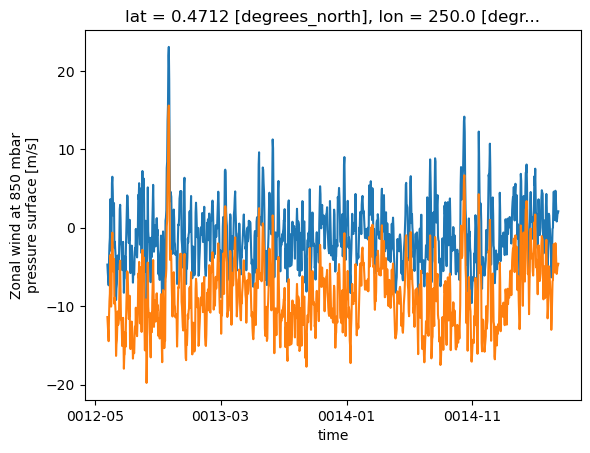

In [18]:
zonal_wind_anom.isel(lat=5,lon=200,case=0,time=slice(365,4*365)).plot()
zonal_wind.U850.isel(lat=5,lon=200,case=0,time=slice(365,4*365)).plot()


In [19]:
# Compute weighted zonal mean
coswgt = np.cos(np.deg2rad(zonal_wind_anom.lat))
zonal_wind_anom_weighted = zonal_wind_anom.weighted(coswgt).mean(('lat'))


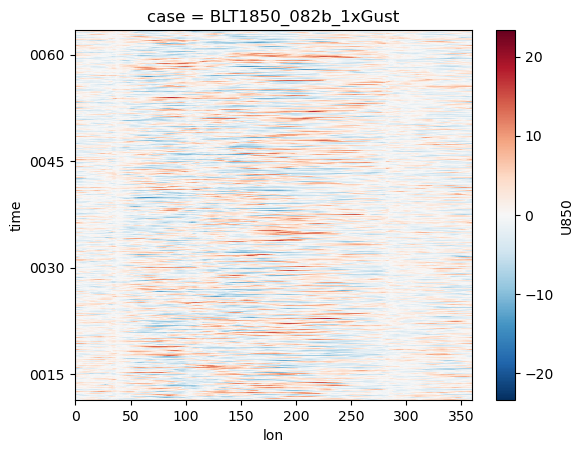

In [35]:
zonal_wind_anom_weighted.isel(case=0).plot()

In [20]:
# Find where values exceed 5
mask = zonal_wind_anom_weighted > 5

# Identify contiguous periods of days
rolling_count = mask.rolling(time=2, center=False).sum()
contiguous_days_mask = rolling_count >= 2



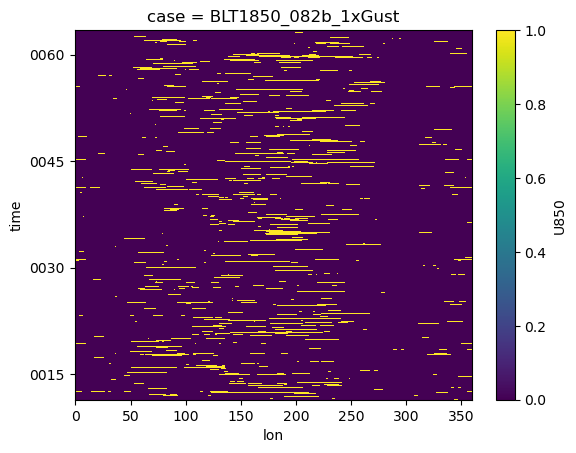

In [44]:
contiguous_days_mask.isel(case=0).plot()

In [21]:
contiguous_days_mask.load()

<xarray.DataArray 'U850' (case: 2, time: 19000, lon: 288)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.3 357.5 358.8
  * time     (time) object 0011-05-30 12:00:00 ... 0063-06-18 12:00:00
  * case     (case) <U19 'BLT1850_082b_1xGust' 'BLT1850_083b_0xGust'
    month    (time) int64 5 5 6 6 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6 6 6 6

In [24]:
def find_finite_stretches(arr):
    # Step 1: Create a boolean array where True indicates a finite value
    finite_mask = arr > 0
    
    # Step 2: Find where the finite values start and end
    changes = np.diff(finite_mask.astype(int))
    
    # Find start of stretches
    starts = np.where(changes == 1)[0] + 1  # +1 to adjust for np.diff offset
    # Find end of stretches
    ends = np.where(changes == -1)[0] 
    
    # Handle edge cases where stretches might start at the beginning or end of the array
    if finite_mask[0]:
        starts = np.concatenate(([0], starts))
    if finite_mask[-1]:
        ends = np.concatenate((ends, [len(arr)-1]))
    
    # Make sure starts and ends are properly aligned
    if len(ends) > len(starts):
        ends = ends[:-1]  # Remove extra end if exists
    
    # Combine starts and ends
    stretches = list(zip(starts, ends))
    
    return stretches


In [25]:
eventsMask = np.zeros([2, len(contiguous_days_mask.time.values), len(contiguous_days_mask.lon.values)])

for iT in range(len(contiguous_days_mask.time.values)): 
    events_case0 = find_finite_stretches(contiguous_days_mask.isel(time=iT,case=0).lon.values * contiguous_days_mask.isel(time=iT,case=0))
    events_case1 = find_finite_stretches(contiguous_days_mask.isel(time=iT,case=1).lon.values * contiguous_days_mask.isel(time=iT,case=1))

    if len(events_case0)>0: 
        for iEvent0 in range(len(events_case0)): 
            lonDiff  = contiguous_days_mask.isel(lon=int(events_case0[iEvent0][1])).lon.values - contiguous_days_mask.isel(lon=int(events_case0[iEvent0][0])).lon.values
            if lonDiff>10: 
                eventsMask[0,iT, int(events_case0[iEvent0][0]):int(events_case0[iEvent0][1])] = 1

    if len(events_case1)>0: 
        for iEvent1 in range(len(events_case1)): 
            lonDiff  = contiguous_days_mask.isel(lon=int(events_case1[iEvent1][1])).lon.values - contiguous_days_mask.isel(lon=int(events_case1[iEvent1][0])).lon.values
            if lonDiff>10: 
                eventsMask[1,iT, int(events_case1[iEvent1][0]):int(events_case1[iEvent1][1])] = 1   



In [50]:
all_h1['WWB_eventMask'] = (('case','time','lon'), eventsMask)


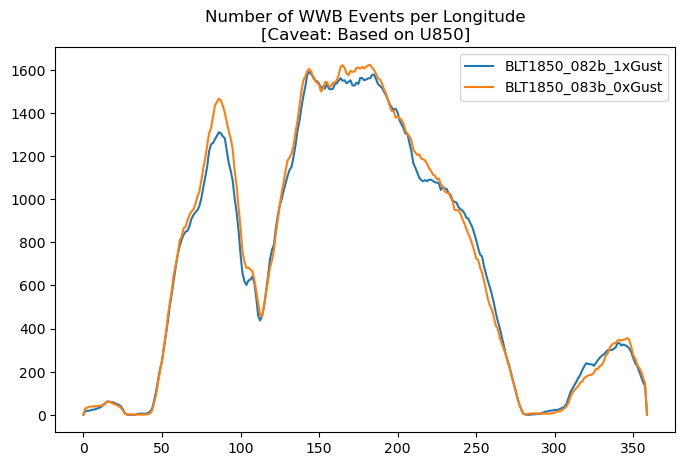

In [48]:
fig,axs=plt.subplots(1,1,figsize=(8,5))
plt.plot(contiguous_days_mask.lon.values, np.nansum(eventsMask[0,:,:],axis=0), label=str(all_h1.case.isel(case=0).values))
plt.plot(contiguous_days_mask.lon.values, np.nansum(eventsMask[1,:,:],axis=0), label=str(all_h1.case.isel(case=1).values))
plt.title('Number of WWB Events per Longitude\n[Caveat: Based on U850]')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Number of events')

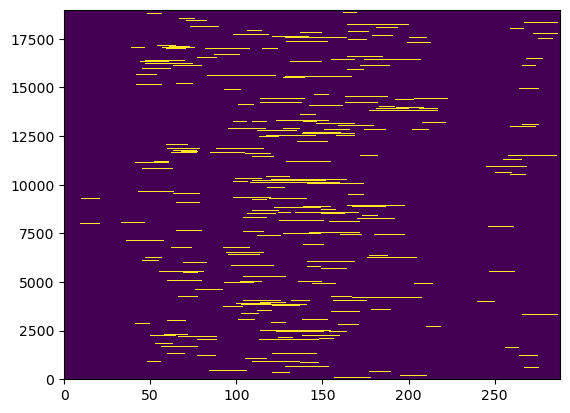

In [28]:
plt.pcolormesh(eventsMask[0,:,:])

In [98]:
# lonStart = []
# lonEnd = []
# if np.any(contiguous_days_mask.isel(time=1,case=0).values==True):
    
#     for iLon in range(len(contiguous_days_mask.lon.values)-1): 
#         if ((contiguous_days_mask.isel(time=1,case=0, lon=iLon).values==False) & 
#             (contiguous_days_mask.isel(time=1,case=0, lon=iLon+1).values==True) ):  
#             lonStart = np.append(lonStart, iLon+1)

#         if ((contiguous_days_mask.isel(time=1,case=0, lon=iLon).values==True) & 
#             (contiguous_days_mask.isel(time=1,case=0, lon=iLon+1).values==False) ):  
#             lonEnd = np.append(lonEnd, iLon)

# print(lonStart)
# print(lonEnd)   

[ 95. 119. 147.]
[106. 142. 148.]


In [100]:

events_case0 = find_finite_stretches(contiguous_days_mask.isel(time=1,case=0).lon.values * contiguous_days_mask.isel(time=1,case=0))

print(events_case0)

[(95, 106), (119, 142), (147, 148)]


In [99]:
for iEvent in range(len(test)): 
    lonDiff = contiguous_days_mask.isel(lon=test[iEvent][1]).lon.values - contiguous_days_mask.isel(lon=test[iEvent][0]).lon.values

    print(lonDiff)

13.750000000000014
28.75
1.2499999999999716


In [102]:
eventsMask = np.zeros([2, len(contiguous_days_mask.time.values), len(contiguous_days_mask.lon.values)])

for iEvent0 in range(len(events_case0)): 
    lonDiff  = contiguous_days_mask.isel(lon=events_case0[iEvent0][1]).lon.values - contiguous_days_mask.isel(lon=events_case0[iEvent0][0]).lon.values
    if lonDiff>10: 
        eventsMask[0,1,int(events_case0[iEvent0][0]):int(events_case0[iEvent0][1])] = 1


In [103]:
eventsMask[0,1,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
## Now need to identify WWB events 
strongEnough = zonal_wind_anom_weighted.where(zonal_wind_anom_weighted>=5)



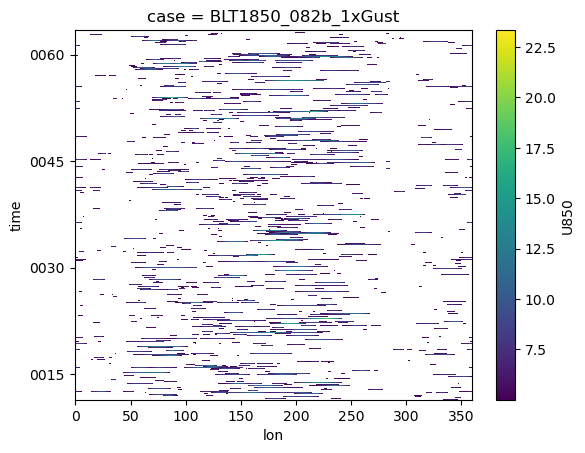

In [40]:
strongEnough.isel(case=0).plot()
